In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
import shap
import platform
import sklearn
import imblearn
import skopt
import numpy
import pandas
import matplotlib
import os, re
import seaborn as sns

# Sklearn / Imblearn
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit, cross_val_predict, cross_val_score
from sklearn.metrics import (roc_auc_score, average_precision_score, precision_recall_curve,
                             precision_score, recall_score, f1_score, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve 
from sklearn.linear_model import LogisticRegression as LR


# BayesSearch
from skopt import BayesSearchCV
from skopt.space import Real, Integer

warnings.filterwarnings("ignore")

In [ ]:
# 0) Paths & Data Loading
MRI_DIR  = Path(r"F:\A7 Learning\2025-2026\master-block1\Thesis_Hanah\dataset_preoperative\mri")
META_DIR = Path(r"F:\A7 Learning\2025-2026\master-block1\Thesis_Hanah\dataset_preoperative\metadata")

PATH_META  = META_DIR / "meta_filtered.csv"
PATH_AREA  = MRI_DIR  / "area_zscores_patients.csv"
PATH_THICK = MRI_DIR  / "thick_zscores_patients.csv"
PATH_VOL   = MRI_DIR  / "vol_zscores_patients.csv"

na_strings = ["NA", "N/A", "missing", "", " "] 
meta  = pd.read_csv(PATH_META,  na_values=na_strings)
area  = pd.read_csv(PATH_AREA,  na_values=na_strings)
thick = pd.read_csv(PATH_THICK, na_values=na_strings)
vol   = pd.read_csv(PATH_VOL,   na_values=na_strings)

meta_cols = set(meta.columns)

def keep_mri_only(df):
    cols = ["ID"] + [c for c in df.columns if (c not in meta_cols) and (c != "ILAE_Year1")]
    return df[cols].drop_duplicates("ID")

area2  = keep_mri_only(area)
thick2 = keep_mri_only(thick)
vol2   = keep_mri_only(vol)

df_all = (meta.drop_duplicates("ID")
              .merge(area2,  on="ID", how="inner")
              .merge(thick2, on="ID", how="inner")
              .merge(vol2,   on="ID", how="inner")).copy()


In [ ]:
# 1) Clinical columns & target
# TRUE/FALSE → 1/0
BOOL_COLS = ["FUS", "FBTCS", "SE"]
for c in BOOL_COLS:
    if c in df_all.columns:
        s = df_all[c]
        if s.dtype == object:
            v = s.astype(str).str.strip().str.upper()
            df_all[c] = (v == "TRUE").astype(float)
        elif s.dtype == bool:
            df_all[c] = s.astype(float)
        else:
            df_all[c] = pd.to_numeric(s, errors="coerce")

BINNED_COLS = ["Binned_Onset_Age", "Binned_Age_at_Scan", "Binned_Age_at_Surgery"]
clin_num_cols_all = ["FUS", "fqFUS", "FBTCS", "fqFBTCS", "SE", "Number_ASMs"]
clin_cat_cols_all = ["Sex"] + BINNED_COLS

clin_num_cols = [c for c in clin_num_cols_all if c in df_all.columns]
clin_cat_cols = [c for c in clin_cat_cols_all if c in df_all.columns]

known = set(["ID", "ILAE_Year1", "y"] + clin_num_cols + clin_cat_cols)
mri_cols = [c for c in df_all.columns if c not in known]

df_all["y"] = (df_all["ILAE_Year1"] > 2).astype(int)

X = df_all.drop(columns=["y", "ILAE_Year1"])
y = df_all["y"].astype(int)
groups = df_all["ID"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, te_idx = next(gss.split(X, y, groups=groups))
X_tr, X_te = X.iloc[tr_idx].reset_index(drop=True), X.iloc[te_idx].reset_index(drop=True)
y_tr, y_te = y.iloc[tr_idx].reset_index(drop=True), y.iloc[te_idx].reset_index(drop=True)
groups_tr, groups_te = groups.iloc[tr_idx].values, groups.iloc[te_idx].values

print(f"Total MRI features: {len(mri_cols)}")
print("Train:", X_tr.shape, "Test:", X_te.shape)

Total MRI features: 220
Train: (332, 231) Test: (83, 231)


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

print("\n=== Class balance overview ===")

# Overall distribution
overall_counts = y.value_counts()
overall_ratio = y.value_counts(normalize=True) * 100
print("Overall class distribution:")
print(pd.concat([overall_counts, overall_ratio.rename("percent")], axis=1))
print("-" * 40)

# Train/Test split distribution
train_counts = y_tr.value_counts()
test_counts = y_te.value_counts()
print("Train distribution:")
print(train_counts)
print("Test distribution:")
print(test_counts)
print("-" * 40)

# Compare proportions
train_ratio = y_tr.value_counts(normalize=True) * 100
test_ratio = y_te.value_counts(normalize=True) * 100
print("Train class ratio (%):")
print(train_ratio.round(2))
print("Test class ratio (%):")
print(test_ratio.round(2))



=== Class balance overview ===
Overall class distribution:
   count    percent
y                  
0    283  68.192771
1    132  31.807229
----------------------------------------
Train distribution:
y
0    228
1    104
Name: count, dtype: int64
Test distribution:
y
0    55
1    28
Name: count, dtype: int64
----------------------------------------
Train class ratio (%):
y
0    68.67
1    31.33
Name: proportion, dtype: float64
Test class ratio (%):
y
0    66.27
1    33.73
Name: proportion, dtype: float64


In [ ]:
# 2) Blind Baseline Selection (Single Clinical Feature via CV)
cv_bl = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

SCORING = "roc_auc"  

# All Candidates: Numerical + Categorical 
candidates = [c for c in clin_num_cols + clin_cat_cols if c in X_tr.columns]
if len(candidates) == 0:
    raise RuntimeError("No clinical candidates found for baseline selection.")

def _build_single_feature_pipeline(feat):
  
    if feat in clin_num_cols:
        prep = ColumnTransformer([
            ('num', Pipeline([
                ('imp', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), [feat])
        ], remainder='drop')
    else:
        prep = ColumnTransformer([
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [feat])
        ], remainder='drop')

    return Pipeline([
        ('prep', prep),
        ('clf', LogisticRegression(random_state=42, solver='liblinear', max_iter=4000))
    ])

# Perform cross-validation scoring for each feature
cv_scores = {}
for feat in candidates:
    pipe = _build_single_feature_pipeline(feat)
    scores = cross_val_score(pipe, X_tr[[feat]], y_tr,
                             cv=cv_bl, groups=groups_tr,
                             scoring=SCORING, n_jobs=-1)
    cv_scores[feat] = float(np.mean(scores))

# Select the highest-scoring individual
best_feat = max(cv_scores, key=cv_scores.get)
best_score = cv_scores[best_feat]

print("[Baseline CV scores]:")
for k,v in cv_scores.items():
    print(f"  {k:<25} {v:.4f}")
print(f"\n[Baseline Selected] {best_feat} (CV {SCORING} = {best_score:.4f})")

# Establish the final baseline pipeline and perform fitting
original_feature_name = best_feat
final_baseline_pipe = _build_single_feature_pipeline(best_feat)
X_tr_baseline = X_tr[[best_feat]]
X_te_baseline = X_te[[best_feat]]
final_baseline_pipe.fit(X_tr_baseline, y_tr)


[Baseline CV scores]:
  FUS                       0.5235
  fqFUS                     0.5698
  FBTCS                     0.5604
  fqFBTCS                   0.6152
  SE                        0.5431
  Number_ASMs               0.4743
  Sex                       0.5241
  Binned_Onset_Age          0.5321
  Binned_Age_at_Scan        0.5045
  Binned_Age_at_Surgery     0.5669

[Baseline Selected] fqFBTCS (CV roc_auc = 0.6152)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fqFBTCS'])])),
                ('clf',
                 LogisticRegression(max_iter=4000, random_state=42,
                                    solver='liblinear'))])

In [ ]:
# 3) Helpers

def pick_tau_constrained_with_topk(y_true, proba, min_prec=0.55, min_rec=0.15, min_spec=0.20,
                                   relax=True, relax_step=0.05, topk_fallback=True):
    y_true = np.asarray(y_true)
    prec, rec, thr = precision_recall_curve(y_true, proba)
    prec, rec = prec[:-1], rec[:-1]

    def _spec_at(t):
        yhat = (proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
        return tn / (tn + fp + 1e-12)

    cur_p, cur_r, cur_s = min_prec, min_rec, min_spec
    while True:
        ok = [i for i, t in enumerate(thr) if (prec[i] >= cur_p) and (rec[i] >= cur_r) and (_spec_at(t) >= cur_s)]
        if ok:
            ok = np.array(ok)
            f1 = 2 * prec * rec / (prec + rec + 1e-12)
            j = ok[np.nanargmax(f1[ok])]
            return float(thr[j]), float(prec[j]), float(rec[j]), float(f1[j])
        if not relax or (cur_p <= 0 and cur_r <= 0 and cur_s <= 0):
            break
        if cur_p > 0:   cur_p = max(0.0, cur_p - relax_step)
        elif cur_s > 0: cur_s = max(0.0, cur_s - relax_step)
        else:           cur_r = max(0.0, cur_r - relax_step)

    if topk_fallback:
        k = max(1, int((y_true==1).sum()))
        order = np.argsort(proba)[::-1]
        tau = float(proba[order[k-1]])
        yhat = (proba >= tau).astype(int)
        P = precision_score(y_true, yhat, zero_division=0)
        R = recall_score(y_true, yhat, zero_division=0)
        F = f1_score(y_true, yhat, zero_division=0)
        return tau, float(P), float(R), float(F)

    f1 = 2 * prec * rec / (prec + rec + 1e-12)
    j = int(np.nanargmax(f1))
    return float(thr[j]), float(prec[j]), float(rec[j]), float(f1[j])

def run_bayes_search_optimization(model_name, pipeline, search_spaces, X_tr_subset, y_tr, groups_tr, n_iter=50):
    print(f"\n--- Optimizing {model_name} using BayesSearchCV ---")
    cv_strategy = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    bayes_search = BayesSearchCV(
        estimator=pipeline, search_spaces=search_spaces, n_iter=n_iter,
        cv=cv_strategy, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=0
    )
    bayes_search.fit(X_tr_subset, y_tr, groups=groups_tr)
    print(f"Best CV ROC-AUC for {model_name}: {bayes_search.best_score_:.4f}")
    return {"name": model_name, "best_estimator": bayes_search.best_estimator_, "best_cv_score": bayes_search.best_score_}

def evaluate_model_and_print(name, y_true_train, proba_test, oof_proba_train):
    MIN_PREC, MIN_SPEC, MIN_REC = 0.55, 0.35, 0.40
    auroc  = roc_auc_score(y_te, proba_test)
    pr_auc = average_precision_score(y_te, proba_test)
    tau, _, _, _ = pick_tau_constrained_with_topk(y_true_train, oof_proba_train, MIN_PREC, MIN_REC, MIN_SPEC)
    yhat = (proba_test >= tau).astype(int)
    prec = precision_score(y_te, yhat, zero_division=0)
    rec  = recall_score(y_te, yhat, zero_division=0)
    f1   = f1_score(y_te, yhat, zero_division=0)
    cm   = confusion_matrix(y_te, yhat, labels=[0,1])

    print("\n" + "-"*50)
    print(f"### Evaluation Report for: {name} ###")
    print(f"Test ROC-AUC:                     {auroc:.4f}")
    print(f"Test PR-AUC (Average Precision):  {pr_auc:.4f}")
    print(f"Optimal Threshold (Tau) found:    {tau:.4f}")
    print("-" * 25)
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("-" * 25)
    print("Confusion Matrix:")
    print(cm)
    print(f"(TN: {cm[0,0]}, FP: {cm[0,1]}, FN: {cm[1,0]}, TP: {cm[1,1]})")
    print("-" * 50)

    return {"Model": name, "ROC_AUC": auroc, "PR_AUC": pr_auc, "Precision": prec, "Recall": rec, "F1": f1, "Tau": tau}


In [ ]:
# 4) Model families
_rfe_base_clf = LogisticRegression(penalty="l2", solver="liblinear", max_iter=3000, random_state=42)

clin_prep = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), clin_num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), clin_cat_cols)
], remainder="drop")

mri_prep_with_rfe = ColumnTransformer([
    ("mri", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler()),
                      ("sel", RFE(estimator=_rfe_base_clf, step=0.2))]), mri_cols)
], remainder="drop")

mri_prep_no_rfe = ColumnTransformer([
    ("mri", Pipeline([("imp", SimpleImputer(strategy="median"))
                      ]), mri_cols)
], remainder="drop")

def get_all_models_for_competition():
    models = {}

    # Clinical search spaces
    temp_prep_ohe = clone(clin_prep).fit(X_tr)
    num_cat_features_ohe = temp_prep_ohe.named_transformers_['cat'].get_feature_names_out().shape[0]
    num_total_clin_features_ohe = len(clin_num_cols) + num_cat_features_ohe

    clin_search_spaces_linear = {
        'sel__n_features_to_select': Integer(3, num_total_clin_features_ohe),
        'smote__k_neighbors': Integer(3, 7),
        'clf__C': Real(0.01, 10.0, 'log-uniform')
    }
    clin_search_spaces_lsvc = {
        'sel__n_features_to_select': Integer(3, num_total_clin_features_ohe),
        'smote__k_neighbors': Integer(3, 7),
        'clf__estimator__C': Real(0.01, 10.0, 'log-uniform')
    }
    clin_search_spaces_rbf_svm = {
        'smote__k_neighbors': Integer(3, 9),
        'clf__C': Real(0.1, 100.0, 'log-uniform'),
        'clf__gamma': Real(1e-4, 1.0, 'log-uniform')
    }

    models['Clin_LogReg'] = (ImbPipeline([("prep", clin_prep), ("sel", RFE(estimator=LogisticRegression(solver='liblinear', random_state=42))),
                                          ("smote", SMOTE(random_state=42)),
                                          ("clf", LogisticRegression(solver='liblinear', random_state=42))]), clin_search_spaces_linear)
    models['Clin_SVM'] = (ImbPipeline([("prep", clin_prep), ("sel", RFE(estimator=LogisticRegression(solver='liblinear', random_state=42))),
                                       ("smote", SMOTE(random_state=42)),
                                       ("clf", SVC(kernel='linear', probability=True, random_state=42))]), clin_search_spaces_linear)
    models['Clin_LSVC'] = (ImbPipeline([("prep", clin_prep), ("sel", RFE(estimator=LogisticRegression(solver='liblinear', random_state=42))),
                                        ("smote", SMOTE(random_state=42)),
                                        ("clf", CalibratedClassifierCV(LinearSVC(random_state=42, max_iter=5000)))]), clin_search_spaces_lsvc)
    models['Clin_HGB'] = (ImbPipeline([("prep", clin_prep),
                                       ("smote", SMOTE(random_state=42)),
                                       ("clf", HistGradientBoostingClassifier(random_state=42))]),
                          {'smote__k_neighbors': Integer(3, 9),
                           'clf__learning_rate': Real(0.01, 0.2, 'log-uniform'),
                           'clf__max_depth': Integer(3, 8)})


    models['Clin_RBF_SVM'] = (ImbPipeline([("prep", clin_prep),
                                           ("sel", RFE(estimator=LogisticRegression(solver='liblinear', random_state=42))),
                                           ("smote", SMOTE(random_state=42)),
                                           ("clf", SVC(kernel='rbf', probability=True, random_state=42))
                                           ]), clin_search_spaces_rbf_svm)
    
    
    # MRI search spaces
    mri_search_spaces_linear = {
        'prep__mri__sel__n_features_to_select': Integer(30, 120),
        'smote__k_neighbors': Integer(3, 7),
        'clf__C': Real(0.01, 10.0, 'log-uniform')
    }
    mri_search_spaces_lsvc = {
        'prep__mri__sel__n_features_to_select': Integer(30, 120),
        'smote__k_neighbors': Integer(3, 7),
        'clf__estimator__C': Real(0.01, 10.0, 'log-uniform')
    }
    mri_search_spaces_hgb = {
        'smote__k_neighbors': Integer(3, 9),
        'clf__learning_rate': Real(0.01, 0.2, 'log-uniform'),
        'clf__max_depth': Integer(5, 15),
        'clf__min_samples_leaf': Integer(20, 100)
    }
    mri_search_spaces_rbf_svm = {
        'smote__k_neighbors': Integer(3, 9),
        'clf__C': Real(0.1, 100.0, 'log-uniform'),
        'clf__gamma': Real(1e-4, 1.0, 'log-uniform')
    }

    models['MRI_LogReg'] = (ImbPipeline([("prep", mri_prep_with_rfe),
                                         ("smote", SMOTE(random_state=42)),
                                         ("clf", LogisticRegression(solver='liblinear', random_state=42))]),
                            mri_search_spaces_linear)

    models['MRI_SVM'] = (ImbPipeline([("prep", mri_prep_with_rfe),
                                      ("smote", SMOTE(random_state=42)),
                                      ("clf", SVC(kernel='linear', probability=True, random_state=42))]),
                         mri_search_spaces_linear)

    models['MRI_LSVC'] = (ImbPipeline([("prep", mri_prep_with_rfe),
                                       ("smote", SMOTE(random_state=42)),
                                       ("clf", CalibratedClassifierCV(LinearSVC(random_state=42, max_iter=5000)))]),
                          mri_search_spaces_lsvc)

    models['MRI_HGB'] = (ImbPipeline([("prep", mri_prep_no_rfe),
                                      ("smote", SMOTE(random_state=42)),
                                      ("clf", HistGradientBoostingClassifier(random_state=42, early_stopping=True))]),
                         mri_search_spaces_hgb)

    models['MRI_RBF_SVM'] = (ImbPipeline([("prep", mri_prep_no_rfe),
                                          ("smote", SMOTE(random_state=42)),
                                          ("clf", SVC(kernel='rbf', probability=True, random_state=42))]),
                             mri_search_spaces_rbf_svm)

    return models


In [12]:
def get_early_fusion_models(early_fusion_prep_lin, early_fusion_prep_norfe):
    models = {}
    ef_search_linear = {
        'prep__mri__sel__n_features_to_select': Integer(30, 150),
        'smote__k_neighbors': Integer(3, 9),
        'clf__C': Real(0.01, 10.0, 'log-uniform')
    }
    models['EF_LogReg'] = (ImbPipeline([('prep', early_fusion_prep_lin),
                                        ('smote', SMOTE(random_state=42)),
                                        ('clf', LogisticRegression(solver='liblinear', random_state=42))]),
                           ef_search_linear)
    models['EF_SVM'] = (ImbPipeline([('prep', early_fusion_prep_lin),
                                     ('smote', SMOTE(random_state=42)),
                                     ('clf', SVC(kernel='linear', probability=True, random_state=42))]),
                        ef_search_linear)
    models['EF_LSVC'] = (ImbPipeline([('prep', early_fusion_prep_lin),
                                      ('smote', SMOTE(random_state=42)),
                                      ('clf', CalibratedClassifierCV(LinearSVC(random_state=42, max_iter=5000)))]),
                         {'prep__mri__sel__n_features_to_select': Integer(30,150),
                          'smote__k_neighbors': Integer(3,9),
                          'clf__estimator__C': Real(0.01,10.0,'log-uniform')})

    # regularized logreg without RFE

    models['EF_HGB'] = (ImbPipeline([('prep', early_fusion_prep_norfe),
                                     ('smote', SMOTE(random_state=42)),
                                     ('clf', HistGradientBoostingClassifier(random_state=42, early_stopping=True))]),
                        {'smote__k_neighbors': Integer(3,9),
                         'clf__learning_rate': Real(0.01,0.2,'log-uniform'),
                         'clf__max_leaf_nodes': Integer(20,50),
                         'clf__max_depth': Integer(5,15)})
    models['EF_RBF_SVM'] = (ImbPipeline([('prep', early_fusion_prep_norfe),
                                         ('smote', SMOTE(random_state=42)),
                                         ('clf', SVC(kernel='rbf', probability=True, random_state=42))]),
                            {'smote__k_neighbors': Integer(3,9),
                             'clf__C': Real(0.1,100.0,'log-uniform'),
                             'clf__gamma': Real(1e-4,1.0,'log-uniform')})
    return models


In [ ]:
# 5) Early Fusion competition

print("\n" + "="*80 + "\n STEP 1: Early-Fusion Multi-Model Competition \n" + "="*80)

_rfe_base_early = LogisticRegression(penalty="l2", solver="liblinear", max_iter=2000, random_state=42)

early_fusion_prep_lin = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), clin_num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), clin_cat_cols),
    ("mri", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler()),
                      ("sel", RFE(estimator=_rfe_base_early, step=0.2))]), mri_cols)
], remainder="drop")

early_fusion_prep_norfe = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), clin_num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), clin_cat_cols),
    ("mri", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), mri_cols)
], remainder="drop")

ef_models = get_early_fusion_models(early_fusion_prep_lin, early_fusion_prep_norfe)

ef_results = []
for name, (pipeline, search_spaces) in ef_models.items():
    n_iter = 100 if any(k in name for k in ['HGB', 'RandomForest', 'RBF']) else 50
    res = run_bayes_search_optimization(name, pipeline, search_spaces, X_tr, y_tr, groups_tr, n_iter=n_iter)
    ef_results.append(res)
    _ = cross_val_score(res["best_estimator"], X_tr, y_tr,
                        cv=StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42),
                        groups=groups_tr, scoring='roc_auc', n_jobs=-1).mean()

best_ef_result = max(ef_results, key=lambda x: x['best_cv_score'])
print("\n" + "-"*50)
print(f"Best Early-Fusion Model: {best_ef_result['name']} (CV AUC: {best_ef_result['best_cv_score']:.4f})")
print("-"*50)


# 6) Single Modality competition

print("\n" + "="*80 + "\n STEP 2: Single Modality Model Competition \n" + "="*80)
all_single_models = get_all_models_for_competition()
all_model_results = []

for name, (pipeline, search_spaces) in all_single_models.items():
    if 'Clin' in name:
        X_tr_subset = X_tr[clin_num_cols + clin_cat_cols]
        n_iter = 100 if any(s in name for s in ['HGB', 'RandomForest', 'RBF_SVM']) else 50
    else:
        X_tr_subset = X_tr[mri_cols]
        n_iter = 150 if any(s in name for s in ['HGB', 'RandomForest', 'RBF_SVM']) else 50
    result = run_bayes_search_optimization(name, pipeline, search_spaces, X_tr_subset, y_tr, groups_tr, n_iter=n_iter)
    all_model_results.append(result)

clin_champions = [r for r in all_model_results if r['name'].startswith('Clin')]
mri_champions  = [r for r in all_model_results if r['name'].startswith('MRI')]

best_clin_result = max(clin_champions, key=lambda x: x['best_cv_score'])
best_mri_result  = max(mri_champions,  key=lambda x: x['best_cv_score'])

print("\n" + "="*40 + "\n--- Champions selected for Late Fusion ---")
print(f"Best Clinical Model: {best_clin_result['name']} (CV AUC: {best_clin_result['best_cv_score']:.4f})")
print(f"Best MRI Model: {best_mri_result['name']} (CV AUC: {best_mri_result['best_cv_score']:.4f})")
print("="*40)





 STEP 1: Early-Fusion Multi-Model Competition 

--- Optimizing EF_LogReg using BayesSearchCV ---
Best CV ROC-AUC for EF_LogReg: 0.5388

--- Optimizing EF_SVM using BayesSearchCV ---
Best CV ROC-AUC for EF_SVM: 0.5365

--- Optimizing EF_LSVC using BayesSearchCV ---
Best CV ROC-AUC for EF_LSVC: 0.5157

--- Optimizing EF_HGB using BayesSearchCV ---
Best CV ROC-AUC for EF_HGB: 0.6398

--- Optimizing EF_RBF_SVM using BayesSearchCV ---
Best CV ROC-AUC for EF_RBF_SVM: 0.5235

--------------------------------------------------
Best Early-Fusion Model: EF_HGB (CV AUC: 0.6398)
--------------------------------------------------

 STEP 2: Single Modality Model Competition 

--- Optimizing Clin_LogReg using BayesSearchCV ---
Best CV ROC-AUC for Clin_LogReg: 0.6446

--- Optimizing Clin_SVM using BayesSearchCV ---
Best CV ROC-AUC for Clin_SVM: 0.6508

--- Optimizing Clin_LSVC using BayesSearchCV ---
Best CV ROC-AUC for Clin_LSVC: 0.6348

--- Optimizing Clin_HGB using BayesSearchCV ---
Best CV ROC-AU

In [ ]:
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

def cv_table_for(models, X_selector, type_label):
    rows = []
    for r in models:
        name = r["name"]
        est  = r["best_estimator"]
        Xsub = X_selector(name)

        roc = cross_val_score(est, Xsub, y_tr, groups=groups_tr, cv=cv, scoring='roc_auc', n_jobs=-1)
        pr  = cross_val_score(est, Xsub, y_tr, groups=groups_tr, cv=cv, scoring='average_precision', n_jobs=-1)
        pre = cross_val_score(est, Xsub, y_tr, groups=groups_tr, cv=cv, scoring='precision', n_jobs=-1)
        rec = cross_val_score(est, Xsub, y_tr, groups=groups_tr, cv=cv, scoring='recall', n_jobs=-1)
        f1  = cross_val_score(est, Xsub, y_tr, groups=groups_tr, cv=cv, scoring='f1', n_jobs=-1)

        rows.append({
            "Type": type_label,
            "Model": name,
            "ROC_AUC": roc.mean(),
            "PR_AUC": pr.mean(),
            "Precision": pre.mean(),
            "Recall": rec.mean(),
            "F1": f1.mean()
        })
    return pd.DataFrame(rows)

# 1) Single Modality: Select corresponding features by model name 
def select_X_single(name):
    if name.startswith("MRI_"):
        return X_tr[mri_cols]
    else:  # Clin_
        return X_tr[clin_num_cols + clin_cat_cols]

df_single = cv_table_for(all_model_results, select_X_single, "Single-Modality")

# 2) Early Fusion: Using Full Features 
def select_X_ef(_name):
    return X_tr  # EF Using Holistic Input from Clinical Data + MRI

df_ef = cv_table_for(ef_results, select_X_ef, "Early-Fusion")

# 3) Merge and sort for unified display
cv_metric_all = (
    pd.concat([df_single, df_ef], ignore_index=True)
      .sort_values(["Type", "ROC_AUC"], ascending=[True, False])
      .reset_index(drop=True)
)

print("\n" + "="*80)
print("### CROSS-VALIDATION PERFORMANCE (Single-Modality vs Early-Fusion) ###")
print("="*80)
with pd.option_context('display.width', 160):
    print(cv_metric_all.round(3))



### CROSS-VALIDATION PERFORMANCE (Single-Modality vs Early-Fusion) ###
               Type         Model  ROC_AUC  PR_AUC  Precision  Recall     F1
0      Early-Fusion        EF_HGB    0.640   0.454      0.502   0.468  0.478
1      Early-Fusion     EF_LogReg    0.539   0.376      0.332   0.435  0.375
2      Early-Fusion        EF_SVM    0.536   0.365      0.372   0.494  0.423
3      Early-Fusion    EF_RBF_SVM    0.523   0.377      0.361   0.170  0.230
4      Early-Fusion       EF_LSVC    0.516   0.355      0.332   0.370  0.348
5   Single-Modality      Clin_HGB    0.651   0.446      0.437   0.521  0.472
6   Single-Modality      Clin_SVM    0.651   0.481      0.425   0.482  0.428
7   Single-Modality   Clin_LogReg    0.645   0.475      0.416   0.590  0.486
8   Single-Modality     Clin_LSVC    0.635   0.464      0.416   0.574  0.480
9   Single-Modality  Clin_RBF_SVM    0.621   0.448      0.364   0.506  0.383
10  Single-Modality       MRI_HGB    0.563   0.391      0.330   0.342  0.331
11  

In [ ]:
# Evaluation helper & baseline eval
final_results_summary = []
cv_late = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=44)
evaluated_names = set()

def _eval_and_append(model_name, estimator, Xtr, Xte):
    if model_name in evaluated_names:
        return
    p_te  = estimator.predict_proba(Xte)[:, 1]
    p_oof = cross_val_predict(estimator, Xtr, y_tr, cv=cv_late, groups=groups_tr, method="predict_proba")[:, 1]
    final_results_summary.append(evaluate_model_and_print(model_name, y_tr, p_te, p_oof))
    evaluated_names.add(model_name)

print("\n" + "="*80 + "\n STEP 0: Evaluating Baseline (Single Feature Model) \n" + "="*80)
if final_baseline_pipe is not None:
    final_baseline_pipe.fit(X_tr_baseline, y_tr)
    baseline_proba_test = final_baseline_pipe.predict_proba(X_te_baseline)[:, 1]
    baseline_proba_oof  = cross_val_predict(final_baseline_pipe, X_tr_baseline, y_tr, cv=cv_late, groups=groups_tr, method="predict_proba")[:, 1]
    baseline_result = evaluate_model_and_print(f"Baseline ({original_feature_name})", y_tr, baseline_proba_test, baseline_proba_oof)
    final_results_summary.append(baseline_result)
    evaluated_names.add(f"Baseline ({original_feature_name})")




 STEP 0: Evaluating Baseline (Single Feature Model) 

--------------------------------------------------
### Evaluation Report for: Baseline (fqFBTCS) ###
Test ROC-AUC:                     0.5890
Test PR-AUC (Average Precision):  0.4047
Optimal Threshold (Tau) found:    0.3014
-------------------------
Precision: 0.4800
Recall:    0.4286
F1-Score:  0.4528
-------------------------
Confusion Matrix:
[[42 13]
 [16 12]]
(TN: 42, FP: 13, FN: 16, TP: 12)
--------------------------------------------------


In [ ]:
# Robust Champion Selection + Late Fusion (Clin + MRI, no per-branch isotonic)

def expected_calibration_error(y, p, n_bins=8):
    qs = np.quantile(p, np.linspace(0,1,n_bins+1))
    m = len(y); ece = 0.0
    for i in range(n_bins):
        mask = (p >= qs[i]) & (p <= qs[i+1] if i==n_bins-1 else p < qs[i+1])
        if mask.sum()==0: 
            continue
        ece += (mask.sum()/m) * abs(y[mask].mean() - p[mask].mean())
    return float(ece)

def cal_corr(y, p, n_bins=8, strategy='quantile'):
    t, q = calibration_curve(y, p, n_bins=n_bins, strategy=strategy)
    if len(t) < 2:
        return 0.0
    return float(np.corrcoef(t, q)[0,1])

def _get_pos_proba(estimator, X):
    proba = estimator.predict_proba(X)
    classes_ = getattr(estimator, "classes_", None)
    if classes_ is None:
        clf = estimator
        while hasattr(clf, "steps"): clf = clf.steps[-1][1]
        classes_ = getattr(clf, "classes_", np.array([0, 1]))
    idx1 = int(np.where(classes_ == 1)[0][0])
    return proba[:, idx1]

def _logit(p, eps=1e-6):
    p = np.clip(p, eps, 1-eps)
    return np.log(p/(1-p))
def _sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
def _fuse_logit(p1, p2, w):
    return _sigmoid(w*_logit(p1) + (1-w)*_logit(p2))

def metrics_from_oof(y_true, p_oof, tag=""):
    roc = roc_auc_score(y_true, p_oof)
    pr  = average_precision_score(y_true, p_oof)
    tau, _, _, _ = pick_tau_constrained_with_topk(
        y_true, p_oof, min_prec=0.55, min_rec=0.40, min_spec=0.35
    )
    yhat = (p_oof >= tau).astype(int)
    cm   = confusion_matrix(y_true, yhat, labels=[0,1])
    return {
        "Name": tag,
        "ROC_AUC": roc,
        "PR_AUC": pr,
        "Precision": precision_score(y_true, yhat, zero_division=0),
        "Recall":    recall_score(y_true, yhat, zero_division=0),
        "F1":        f1_score(y_true, yhat, zero_division=0),
        "Tau":       tau,
        "CM":        cm
    }



# 1) Select the champion (if one already exists, retain it)
def pick_champion_robust(candidates, Xtr_subset, tag="MRI"):
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    report = []
    for r in candidates:
        name = r['name']; est = r['best_estimator']
        scores = cross_val_score(est, Xtr_subset, y_tr, cv=cv, groups=groups_tr,
                                 scoring='roc_auc', n_jobs=-1)
        cv_mean, cv_std = float(np.mean(scores)), float(np.std(scores))
        oof_proba = cross_val_predict(est, Xtr_subset, y_tr, cv=cv, groups=groups_tr,
                                      method="predict_proba")
        classes_ = getattr(est, "classes_", np.array([0,1]))
        if classes_ is None and hasattr(est, "predict_proba"):
            clf = est
            while hasattr(clf, "steps"): clf = clf.steps[-1][1]
            classes_ = getattr(clf, "classes_", np.array([0,1]))
        idx1 = int(np.where(classes_ == 1)[0][0])
        oof_p1 = oof_proba[:, idx1]
        r_corr = cal_corr(y_tr, oof_p1, n_bins=8)
        ece    = expected_calibration_error(y_tr, oof_p1, n_bins=8)
        report.append({"name": name, "est": est, "cv_mean": cv_mean, "cv_std": cv_std, "r_corr": r_corr, "ece": ece})

    LAMBDA, MU, MIN_R, MAX_ECE = 0.5, 0.2, 0.05, 0.12
    ok = [d for d in report if (d["r_corr"] > MIN_R and d["ece"] <= MAX_ECE)]
    pool = ok if ok else report
    for d in pool:
        d["robust_score"] = d["cv_mean"] - LAMBDA*d["cv_std"] - MU*d["ece"]
    best = max(pool, key=lambda d: d["robust_score"])

    print(f"\n[Robust Champion Selection - {tag}]")
    print("{:<18}  CVmean  CVstd   r_corr  ECE    RobustScore".format("Model"))
    for d in sorted(pool, key=lambda x: x["robust_score"], reverse=True):
        print("{:<18}  {:6.3f}  {:6.3f}  {:6.3f}  {:5.3f}  {:6.3f}".format(
            d["name"], d["cv_mean"], d["cv_std"], d["r_corr"], d["ece"], d["robust_score"]))
    return {"name": best["name"], "best_estimator": best["est"], "best_cv_score": best["cv_mean"], "report": pd.DataFrame(report)}

try:
    best_clin_result
    best_mri_result
    print("[INFO] Using cached champion results.")
except NameError:
    best_clin_result = max([r for r in all_model_results if r['name'].startswith('Clin')],
                           key=lambda x: x['best_cv_score'])
    best_mri_result  = pick_champion_robust([r for r in all_model_results if r['name'].startswith('MRI')],
                                            X_tr[mri_cols], tag="MRI")

best_clin_model = best_clin_result['best_estimator']
best_mri_model  = best_mri_result['best_estimator']
best_clin_name  = best_clin_result['name']
best_mri_name   = best_mri_result['name']
print(f"[INFO] Champions selected → Clin: {best_clin_name} | MRI: {best_mri_name}")


# 2) Training Side (CV/OOF): Generate OOF Probability & Train Fusion (without per-branch isotonic)
cv_late = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=44)

Xtr_clin = X_tr[clin_num_cols + clin_cat_cols]
Xtr_mri  = X_tr[mri_cols]
Xte_clin = X_te[clin_num_cols + clin_cat_cols]
Xte_mri  = X_te[mri_cols]

# OOF Probability (Single Modality)
pclin_oof_base = cross_val_predict(best_clin_model, Xtr_clin, y_tr, cv=cv_late, groups=groups_tr,
                                   method="predict_proba")[:,1]
pmri_oof_base  = cross_val_predict(best_mri_model,  Xtr_mri,  y_tr, cv=cv_late, groups=groups_tr,
                                   method="predict_proba")[:,1]

# No separate calibration: Raw probabilities are directly fed into fusion.
pclin_oof_cal = pclin_oof_base
pmri_oof_cal  = pmri_oof_base

# Late-Fusion（stacking + blending）Use OOF as training input
Z_tr = np.column_stack([
    pclin_oof_cal,
    pmri_oof_cal,
    pmri_oof_cal - pclin_oof_cal,
    pmri_oof_cal * pclin_oof_cal
])
meta_model = LR(penalty="l2", solver="lbfgs", C=1.0, random_state=42, max_iter=5000).fit(Z_tr, y_tr)
p_stacking_oof = meta_model.predict_proba(Z_tr)[:,1]

best_w, best_ap = 0.0, -np.inf
for w in np.linspace(0.05, 0.95, 19):
    ap = average_precision_score(y_tr, w*pclin_oof_cal + (1-w)*pmri_oof_cal)
    if ap > best_ap:
        best_ap, best_w = ap, w
p_blend_oof = _fuse_logit(pclin_oof_cal, pmri_oof_cal, best_w)


# 3) Training Endpoint (CV/OOF) Visualization + CV/OOF Metrics Table
cv_clin   = metrics_from_oof(y_tr, pclin_oof_cal, tag=f"{best_clin_name} (raw)")
cv_mri    = metrics_from_oof(y_tr, pmri_oof_cal,  tag=f"{best_mri_name} (raw)")
cv_fuse_b = metrics_from_oof(y_tr, p_blend_oof,   tag=f"Late-Fusion (blend, w={best_w:.2f})")
cv_fuse_s = metrics_from_oof(y_tr, p_stacking_oof,tag="Late-Fusion (stacking)")

cv_late_table = pd.DataFrame([cv_clin, cv_mri, cv_fuse_b, cv_fuse_s])[["Name","ROC_AUC","PR_AUC","Precision","Recall","F1","Tau"]]
print("\n" + "="*80)
print("### LATE-FUSION — CV/OOF METRICS (threshold from OOF constrained rule) ###")
print("="*80)
with pd.option_context('display.width', 160):
    print(cv_late_table.round(3))

print("\n[Confusion Matrices @ OOF-τ]")
for row in [cv_clin, cv_mri, cv_fuse_b, cv_fuse_s]:
    print(f"{row['Name']}:")
    print(row["CM"])

[INFO] Using cached champion results.
[INFO] Champions selected → Clin: Clin_HGB | MRI: MRI_RBF_SVM

### LATE-FUSION — CV/OOF METRICS (threshold from OOF constrained rule) ###
                          Name  ROC_AUC  PR_AUC  Precision  Recall     F1    Tau
0               Clin_HGB (raw)    0.652   0.453      0.462   0.529  0.493  0.516
1            MRI_RBF_SVM (raw)    0.504   0.318      0.305   0.577  0.399  0.348
2  Late-Fusion (blend, w=0.45)    0.654   0.452      0.458   0.529  0.491  0.421
3       Late-Fusion (stacking)    0.652   0.453      0.452   0.538  0.491  0.351

[Confusion Matrices @ OOF-τ]
Clin_HGB (raw):
[[164  64]
 [ 49  55]]
MRI_RBF_SVM (raw):
[[ 91 137]
 [ 44  60]]
Late-Fusion (blend, w=0.45):
[[163  65]
 [ 49  55]]
Late-Fusion (stacking):
[[160  68]
 [ 48  56]]


In [ ]:
late_rows = pd.DataFrame([
    {"Type":"Late-Fusion","Model":"Late-Fusion (blend)",   **{k:v for k,v in cv_fuse_b.items() if k in ["ROC_AUC","PR_AUC","Precision","Recall","F1"]}},
    {"Type":"Late-Fusion","Model":"Late-Fusion (stacking)",**{k:v for k,v in cv_fuse_s.items() if k in ["ROC_AUC","PR_AUC","Precision","Recall","F1"]}},
])
 
# The baseline is also included in the comparison
if 'baseline_proba_oof' in globals():
    base_metrics = metrics_from_oof(
        y_tr, baseline_proba_oof, tag=f"Baseline ({original_feature_name})"
    )
    base_row = {
        "Type": "Baseline",
        "Model": base_metrics["Name"],
        "ROC_AUC": base_metrics["ROC_AUC"],
        "PR_AUC":  base_metrics["PR_AUC"],
        "Precision": base_metrics["Precision"],
        "Recall":    base_metrics["Recall"],
        "F1":        base_metrics["F1"],
    }
    late_rows = pd.concat([pd.DataFrame([base_row]), late_rows], ignore_index=True)


cv_metric_all_big = (
    pd.concat([cv_metric_all, late_rows], ignore_index=True)
      .sort_values(["Type","ROC_AUC"], ascending=[True, False])
      .reset_index(drop=True)
)

print("\n" + "="*80)
print("### CROSS-VALIDATION PERFORMANCE — ALL FRAMEWORKS (Single / Early / Late / Baseline) ###")
print("="*80)
with pd.option_context('display.width', 180):
    print(cv_metric_all_big.round(3))



### CROSS-VALIDATION PERFORMANCE — ALL FRAMEWORKS (Single / Early / Late / Baseline) ###
               Type                   Model  ROC_AUC  PR_AUC  Precision  Recall     F1
0          Baseline      Baseline (fqFBTCS)    0.573   0.421      0.376   0.538  0.443
1      Early-Fusion                  EF_HGB    0.640   0.454      0.502   0.468  0.478
2      Early-Fusion               EF_LogReg    0.539   0.376      0.332   0.435  0.375
3      Early-Fusion                  EF_SVM    0.536   0.365      0.372   0.494  0.423
4      Early-Fusion              EF_RBF_SVM    0.523   0.377      0.361   0.170  0.230
5      Early-Fusion                 EF_LSVC    0.516   0.355      0.332   0.370  0.348
6       Late-Fusion     Late-Fusion (blend)    0.654   0.452      0.458   0.529  0.491
7       Late-Fusion  Late-Fusion (stacking)    0.652   0.453      0.452   0.538  0.491
8   Single-Modality                Clin_HGB    0.651   0.446      0.437   0.521  0.472
9   Single-Modality                Clin_

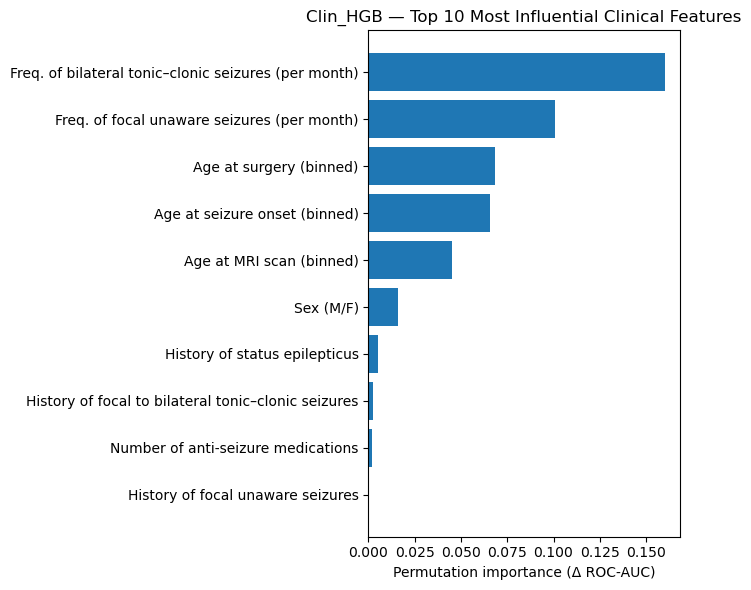

              feature                                          description  importance    std
              fqFBTCS Freq. of bilateral tonic–clonic seizures (per month)      0.1603 0.0151
                fqFUS          Freq. of focal unaware seizures (per month)      0.1008 0.0113
Binned_Age_at_Surgery                              Age at surgery (binned)      0.0685 0.0118
     Binned_Onset_Age                        Age at seizure onset (binned)      0.0658 0.0166
   Binned_Age_at_Scan                             Age at MRI scan (binned)      0.0451 0.0102
                  Sex                                            Sex (M/F)      0.0158 0.0051
                   SE                        History of status epilepticus      0.0052 0.0014
                FBTCS  History of focal to bilateral tonic–clonic seizures      0.0023 0.0014
          Number_ASMs                   Number of anti-seizure medications      0.0018 0.0018
                  FUS                    History of focal un

In [ ]:
# feature mapping
feature_mapping = {
    "Sex": "Sex (M/F)",
    "Binned_Onset_Age": "Age at seizure onset (binned)",
    "FUS": "History of focal unaware seizures",
    "fqFUS": "Freq. of focal unaware seizures (per month)",
    "FBTCS": "History of focal to bilateral tonic–clonic seizures",
    "fqFBTCS": "Freq. of bilateral tonic–clonic seizures (per month)",
    "SE": "History of status epilepticus",
    "Op_Side": "Operated hemisphere (L/R)",
    "Op_Type": "Surgical procedure type (T Lx / T Lesx)",
    "Pathology": "Histopathological diagnosis",
    "Number_ASMs": "Number of anti-seizure medications",
    "Binned_Age_at_Scan": "Age at MRI scan (binned)",
    "Binned_Age_at_Surgery": "Age at surgery (binned)",
    "ILAE_Year1": "Postoperative seizure outcome (ILAE Year 1)"
}

# Obtain the optimal clinical model and fit it 
clin_est = best_clin_model
Xtr_clin = X_tr[clin_num_cols + clin_cat_cols]

clin_est.fit(Xtr_clin, y_tr)

# permutation importance
perm = permutation_importance(clin_est, Xtr_clin, y_tr,
                              n_repeats=10, random_state=42, scoring="roc_auc")

imp = pd.DataFrame({
    "feature": Xtr_clin.columns,
    "importance": perm.importances_mean,
    "std": perm.importances_std
})

imp["description"] = imp["feature"].map(feature_mapping).fillna(imp["feature"])
imp = imp.sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(7,6))
plt.barh(imp["description"][::-1], imp["importance"][::-1])
plt.xlabel("Permutation importance (Δ ROC-AUC)")
plt.title("Clin_HGB — Top 10 Most Influential Clinical Features")
plt.tight_layout()
plt.show()

print(imp[["feature","description","importance","std"]].round(4).to_string(index=False))


 Aggregated SHAP across CV folds: (332, 42), (332, 42)


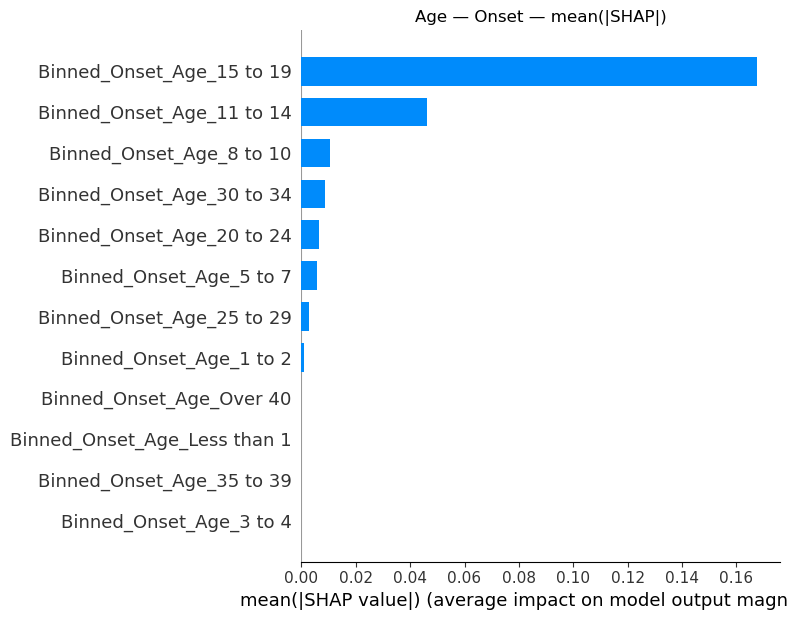

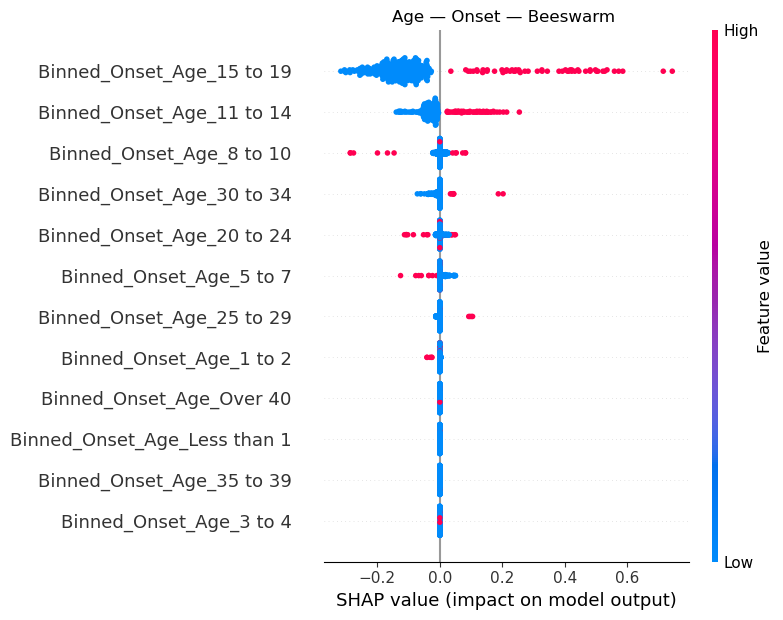

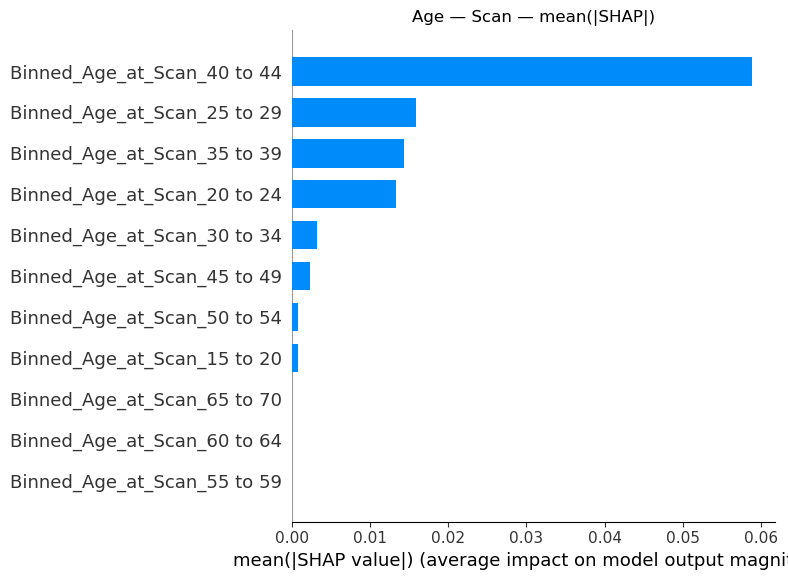

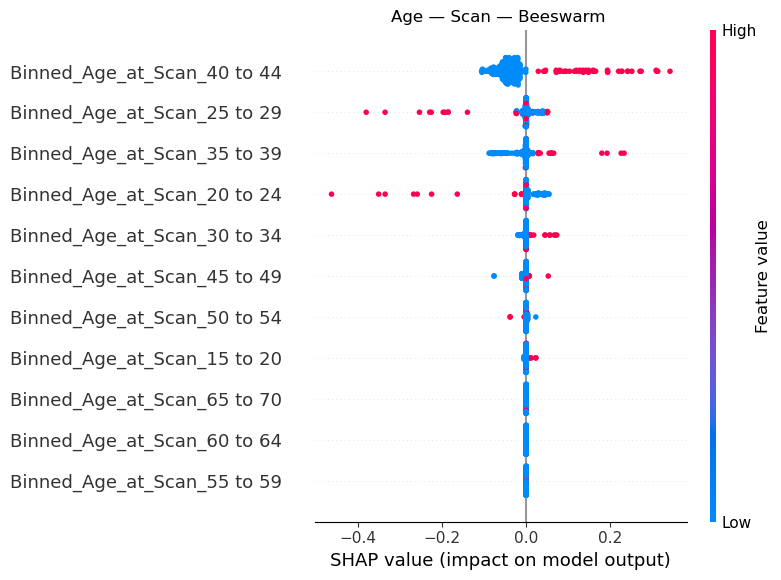

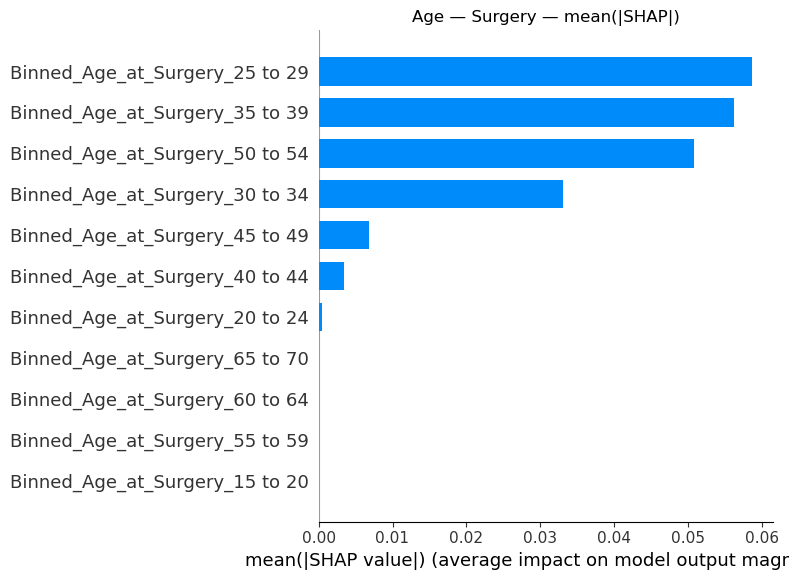

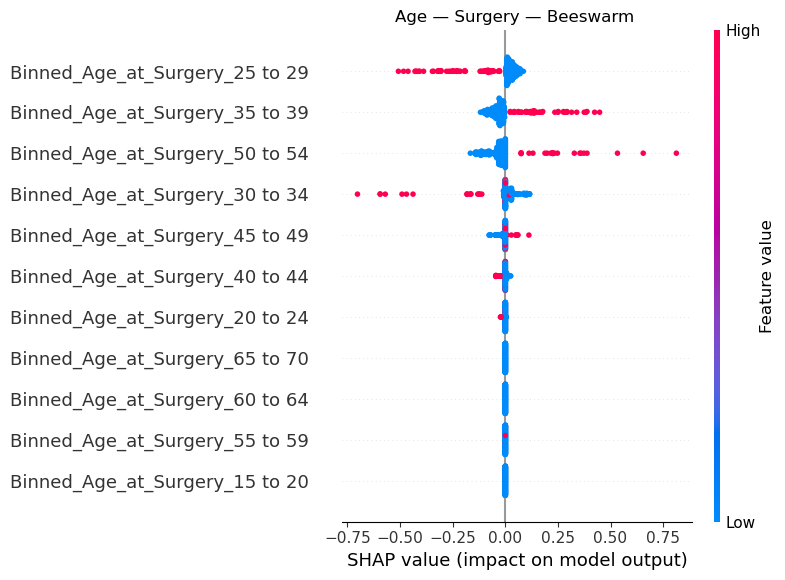

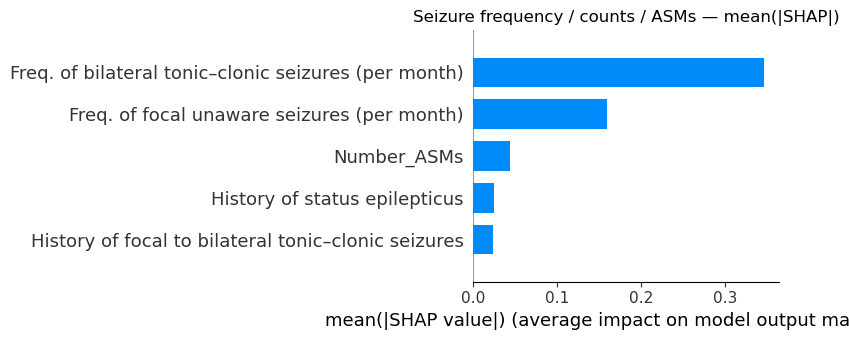

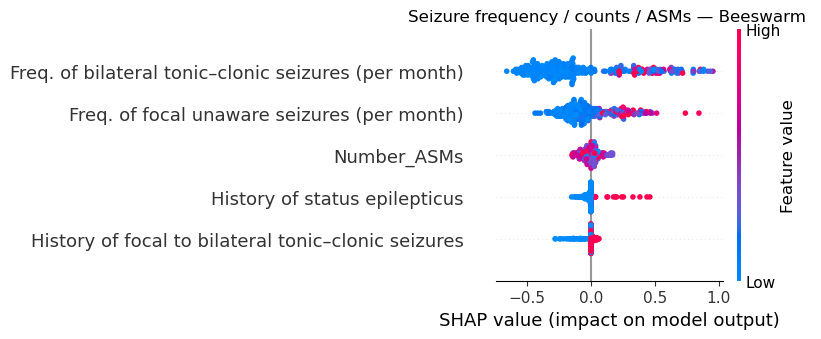

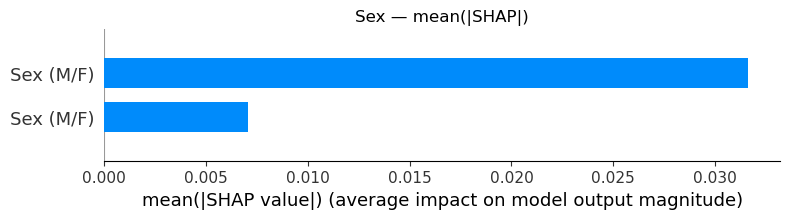

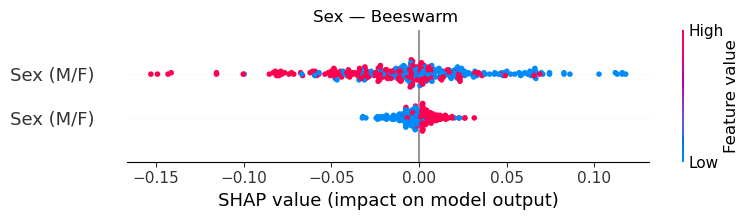

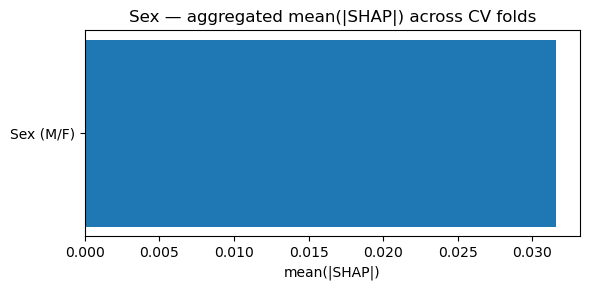

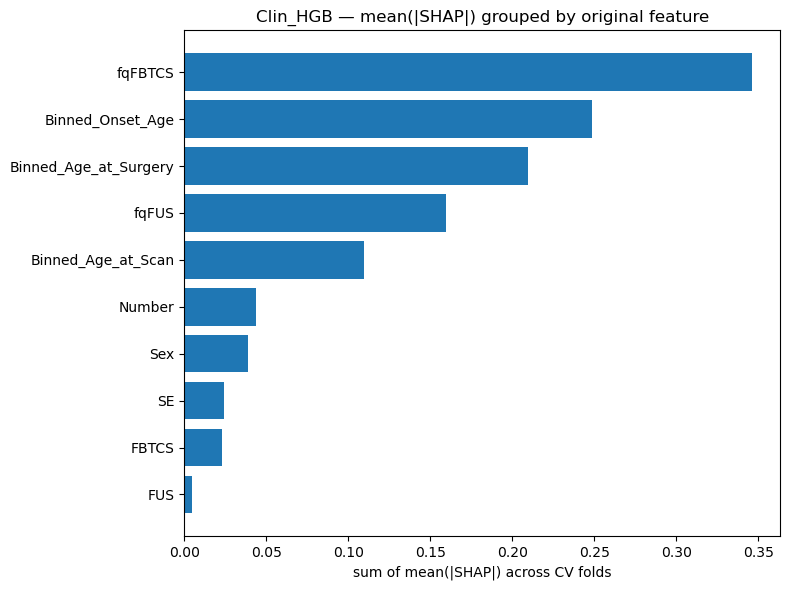

 All subgroup SHAP figures saved to: f:\A7 Learning\2025-2026\master-block1\Thesis_Hanah\exploration\fig_shap_clin_cv


In [ ]:
# Clin_HGB — CV-level Subgroup SHAP Analysis (Full Version)

OUT_DIR = "fig_shap_clin_cv"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) Data and Models 
X_clin = X_tr[clin_num_cols + clin_cat_cols].copy()
y = y_tr
groups = groups_tr
prep = best_clin_model.named_steps['prep']
clf_proto = best_clin_model.named_steps['clf']

# 2) Feature mapping
feature_mapping = {
    "Sex": "Sex (M/F)",
    "Binned_Onset_Age": "Age at seizure onset (binned)",
    "FUS": "History of focal unaware seizures",
    "fqFUS": "Freq. of focal unaware seizures (per month)",
    "FBTCS": "History of focal to bilateral tonic–clonic seizures",
    "fqFBTCS": "Freq. of bilateral tonic–clonic seizures (per month)",
    "SE": "History of status epilepticus",
    "Op_Side": "Operated hemisphere (L/R)",
    "Op_Type": "Surgical procedure type",
    "Pathology": "Histopathological diagnosis",
    "Number_ASMs": "Number of anti-seizure medications",
    "Binned_Age_at_Scan": "Age at MRI scan (binned)",
    "Binned_Age_at_Surgery": "Age at surgery (binned)",
}

def orig_feature(col):
    s = str(col).split("__",1)[-1]
    return s.rsplit("_",1)[0] if "_" in s else s

# 3) Aggregated CV-level SHAP 
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
all_sv, all_Xt = [], []

for fold, (tr_idx, val_idx) in enumerate(cv.split(X_clin, y, groups)):
    X_tr_fold, X_val_fold = X_clin.iloc[tr_idx], X_clin.iloc[val_idx]
    y_tr_fold = y.iloc[tr_idx]
    pipe = best_clin_model
    pipe.fit(X_tr_fold, y_tr_fold)
    Xt_val = pipe.named_steps["prep"].transform(X_val_fold)
    clf = pipe.named_steps["clf"]
    explainer = shap.TreeExplainer(clf)
    sv_fold = explainer.shap_values(Xt_val)
    all_sv.append(sv_fold)
    all_Xt.append(Xt_val)

Xt_all = np.vstack(all_Xt)
sv_all = np.vstack(all_sv)
feat_names = pipe.named_steps["prep"].get_feature_names_out()
name2idx = {n:i for i,n in enumerate(feat_names)}
print(f" Aggregated SHAP across CV folds: {Xt_all.shape}, {sv_all.shape}")

# 4) Grouping
def pick(pattern):
    patt = re.compile(pattern)
    return [c for c in feat_names if patt.search(str(c))]

groups_map = {
    "Age — Onset":   pick("Onset_Age"),
    "Age — Scan":    pick("Age_at_Scan"),
    "Age — Surgery": pick("Age_at_Surgery"),
    "Seizure frequency / counts / ASMs": 
        [c for c in feat_names if any(k in str(c) for k in ["fqFBTCS","fqFUS","_FBTCS","_SE","Number_ASMs"])],
    "Sex": pick("Sex_"),
}

def map_feature_name(raw):
    s = str(raw).split("__",1)[-1]
    base = s.split("_")[0]
    return feature_mapping.get(base, s)

# 5) Drawing
def plot_group_clean(sv, Xt, feat_names, cols, title, max_display=25, figsize=(8,7)):
    if not cols:
        print(f"[skip] {title}: empty set"); 
        return
    idx = [name2idx[c] for c in cols if c in name2idx]
    display_names = [map_feature_name(feat_names[i]) for i in idx]
    
    # Bar plot
    plt.figure(figsize=figsize)
    shap.summary_plot(sv[:, idx], Xt[:, idx],
                      feature_names=display_names,
                      plot_type="bar", show=False)
    plt.gcf().subplots_adjust(left=0.45)
    plt.title(f"{title} — mean(|SHAP|)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"{title.replace('/','-').replace(' ','_')}_bar.png"), dpi=250)
    plt.show()

    # Beeswarm plot
    plt.figure(figsize=figsize)
    shap.summary_plot(sv[:, idx], Xt[:, idx],
                      feature_names=display_names,
                      show=False)
    plt.gcf().subplots_adjust(left=0.45)
    plt.title(f"{title} — Beeswarm ")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"{title.replace('/','-').replace(' ','_')}_beeswarm.png"), dpi=250)
    plt.show()


for title, cols in groups_map.items():
    max_d = max(len(cols), 30)
    plot_group_clean(sv_all, Xt_all, feat_names, cols, title, max_display=max_d)
    

sex_cols = groups_map["Sex"]
if sex_cols:
    idx = [name2idx[c] for c in sex_cols if c in name2idx]
    mean_vals = np.abs(sv_all[:, idx]).mean(axis=0)
    sex_display_names = [map_feature_name(feat_names[i]) for i in idx]
    sex_summary = pd.DataFrame({"Sex_var": sex_display_names, "mean|SHAP|": mean_vals})
    
    plt.figure(figsize=(6,3))
    plt.barh(sex_summary["Sex_var"], sex_summary["mean|SHAP|"])
    plt.gca().invert_yaxis()
    plt.title("Sex — aggregated mean(|SHAP|) across CV folds")
    plt.xlabel("mean(|SHAP|)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "Sex_collapsed_summary_CV.png"), dpi=250)
    plt.show()


raw_groups = pd.Series(feat_names).map(orig_feature)
group_mean_abs = pd.DataFrame({
    "group": raw_groups,
    "val": np.abs(sv_all).mean(axis=0)
}).groupby("group")["val"].sum().sort_values(ascending=False)

plt.figure(figsize=(8,6))
topk = group_mean_abs.head(15)
plt.barh(topk.index[::-1], topk.values[::-1])
plt.title("Clin_HGB — mean(|SHAP|) grouped by original feature")
plt.xlabel("sum of mean(|SHAP|) across CV folds")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "Clin_HGB_grouped_by_original_feature_bar_CV.png"), dpi=250)
plt.show()

print(f" All subgroup SHAP figures saved to: {os.path.abspath(OUT_DIR)}")


In [ ]:
# Evaluate ALL candidates on TEST (each with its own OOF-τ)

cv_for_oof = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=44)

def _select_X_by_name(name, X_tr, X_te):

    if name.startswith("MRI_"):
        return (X_tr[mri_cols], X_te[mri_cols])
    elif name.startswith("Clin_"):
        return (X_tr[clin_num_cols + clin_cat_cols], X_te[clin_num_cols + clin_cat_cols])
    elif name.startswith("EF_"):
        return (X_tr, X_te)
    elif name.startswith("Baseline"):
        feat = name.split("(")[-1].replace(")", "").strip()
        return (X_tr[[feat]], X_te[[feat]])
    else:
        raise ValueError(f"Unknown model prefix for: {name}")

def _prob_pos(estimator, X):
    proba = estimator.predict_proba(X)
    classes_ = getattr(estimator, "classes_", None)
    if classes_ is None:
        clf = estimator
        while hasattr(clf, "steps"):
            clf = clf.steps[-1][1]
        classes_ = getattr(clf, "classes_", np.array([0,1]))
    idx1 = int(np.where(classes_ == 1)[0][0])
    return proba[:, idx1]

def _eval_test_once(name, est, Xtr, Xte):
    # 1) Out-of-Frame probability (training side) → Select τ
    p_oof = cross_val_predict(est, Xtr, y_tr, cv=cv_for_oof, groups=groups_tr, method="predict_proba")
   
    classes_ = getattr(est, "classes_", np.array([0,1]))
    if classes_ is None and hasattr(est, "predict_proba"):
        clf = est
        while hasattr(clf, "steps"):
            clf = clf.steps[-1][1]
        classes_ = getattr(clf, "classes_", np.array([0,1]))
    idx1 = int(np.where(classes_ == 1)[0][0])
    p_oof_1 = p_oof[:, idx1]

    tau, _, _, _ = pick_tau_constrained_with_topk(
        y_tr, p_oof_1, min_prec=0.55, min_rec=0.40, min_spec=0.35
    )

    # 2) Fit the entire training set → Test probability
    est.fit(Xtr, y_tr)
    p_te = _prob_pos(est, Xte)

    # 3) Test Metrics
    yhat = (p_te >= tau).astype(int)
    cm = confusion_matrix(y_te, yhat, labels=[0,1])
    return {
        "Type": ("Single-Modality" if name.startswith(("MRI_","Clin_")) else "Early-Fusion"),
        "Model": name,
        "ROC_AUC": roc_auc_score(y_te, p_te),
        "PR_AUC": average_precision_score(y_te, p_te),
        "Precision": precision_score(y_te, yhat, zero_division=0),
        "Recall": recall_score(y_te, yhat, zero_division=0),
        "F1": f1_score(y_te, yhat, zero_division=0),
        "Tau(OOF)": float(tau),
        "CM": cm
    }

# Collect all models 
# 1) Single-mode
all_to_eval = []
for r in all_model_results:
    all_to_eval.append((r["name"], clone(r["best_estimator"])))

# 2) Early integration
for r in ef_results:
    all_to_eval.append((r["name"], clone(r["best_estimator"])))

# Baseline Single-Feature Model
if 'final_baseline_pipe' in globals():
    all_to_eval.append((f"Baseline ({original_feature_name})", clone(final_baseline_pipe)))


test_reports_all = []
for name, est in all_to_eval:
    Xtr_sel, Xte_sel = _select_X_by_name(name, X_tr, X_te)
    try:
        rep = _eval_test_once(name, est, Xtr_sel, Xte_sel)
        test_reports_all.append(rep)
        print(f"[OK] {name}")
    except Exception as e:
        print(f"[Skip] {name} → {e}")

# Table
test_summary_all = (pd.DataFrame([{k:v for k,v in r.items() if k!='CM'} for r in test_reports_all])
                    .sort_values(["Type","ROC_AUC"], ascending=[True, False])
                    .reset_index(drop=True))


# 1) Ensure the probability of clinical and MRI tests
best_clin_model.fit(X_tr[clin_num_cols + clin_cat_cols], y_tr)
best_mri_model.fit(X_tr[mri_cols], y_tr)
pclin_te = best_clin_model.predict_proba(X_te[clin_num_cols + clin_cat_cols])[:,1]
pmri_te  = best_mri_model.predict_proba(X_te[mri_cols])[:,1]

# 2) Calculate the fusion probability
Z_te = np.column_stack([pclin_te, pmri_te, pmri_te - pclin_te, pmri_te * pclin_te])
p_stack_te = meta_model.predict_proba(Z_te)[:,1]                 # stacking
p_blend_te = _fuse_logit(pclin_te, pmri_te, best_w)              # blend

# 3) Calculate τ for each using the OOF probability from the training endpoint.
tau_blend,  _, _, _ = pick_tau_constrained_with_topk(y_tr, p_blend_oof,   0.55, 0.40, 0.35)
tau_stack,  _, _, _ = pick_tau_constrained_with_topk(y_tr, p_stacking_oof, 0.55, 0.40, 0.35)

# 4) Calculate metrics on Test and add them to the table
for name, p_te, tau in [
    (f"Late-Fusion (blend, w={best_w:.2f})", p_blend_te, tau_blend),
    ("Late-Fusion (stacking)", p_stack_te, tau_stack)
]:
    yhat = (p_te >= tau).astype(int)
    test_reports_all.append({
        "Type": "Late-Fusion",
        "Model": name,
        "ROC_AUC": roc_auc_score(y_te, p_te),
        "PR_AUC": average_precision_score(y_te, p_te),
        "Precision": precision_score(y_te, yhat, zero_division=0),
        "Recall": recall_score(y_te, yhat, zero_division=0),
        "F1": f1_score(y_te, yhat, zero_division=0),
        "Tau(OOF)": tau
    })

test_summary_all = pd.DataFrame([{k:v for k,v in r.items() if k!='CM'} for r in test_reports_all])
print("\n" + "="*80)
print("### TEST SUMMARY — ALL + LATE-FUSION ###")
print("="*80)
print(test_summary_all.round(3))



[OK] Clin_LogReg
[OK] Clin_SVM
[OK] Clin_LSVC
[OK] Clin_HGB
[OK] Clin_RBF_SVM
[OK] MRI_LogReg
[OK] MRI_SVM
[OK] MRI_LSVC
[OK] MRI_HGB
[OK] MRI_RBF_SVM
[OK] EF_LogReg
[OK] EF_SVM
[OK] EF_LSVC
[OK] EF_HGB
[OK] EF_RBF_SVM
[OK] Baseline (fqFBTCS)

### TEST SUMMARY — ALL + LATE-FUSION ###
               Type                        Model  ROC_AUC  PR_AUC  Precision  \
0   Single-Modality                  Clin_LogReg    0.581   0.421      0.382   
1   Single-Modality                     Clin_SVM    0.595   0.438      0.373   
2   Single-Modality                    Clin_LSVC    0.532   0.403      0.367   
3   Single-Modality                     Clin_HGB    0.612   0.470      0.441   
4   Single-Modality                 Clin_RBF_SVM    0.569   0.397      0.381   
5   Single-Modality                   MRI_LogReg    0.670   0.504      0.383   
6   Single-Modality                      MRI_SVM    0.586   0.458      0.333   
7   Single-Modality                     MRI_LSVC    0.666   0.502      0.43

In [ ]:
# SUPER-SHORT CM SCRIPT (with returns) 


def _get_est(name, pool):
    for r in pool:
        if r["name"] == name:
            return clone(r["best_estimator"])
    raise ValueError(f"{name} not found.")

def _select_X(name):
    if name.startswith("MRI_"):
        return X_tr[mri_cols], X_te[mri_cols]
    elif name.startswith("Clin_"):
        return X_tr[clin_num_cols + clin_cat_cols], X_te[clin_num_cols + clin_cat_cols]
    else:  
        return X_tr, X_te

def cm_simple(name, pool, tag=None):
    est = _get_est(name, pool)
    Xtr_sel, Xte_sel = _select_X(name)

    # 1) Out-of-frame probability → Select τ (on the training set)
    p_oof = cross_val_predict(
        est, Xtr_sel, y_tr,
        cv=cv_for_oof, groups=groups_tr,
        method="predict_proba"
    )
    classes_ = getattr(est, "classes_", np.array([0, 1]))
    if classes_ is None and hasattr(est, "predict_proba"):
        last = est
        while hasattr(last, "steps"):
            last = last.steps[-1][1]
        classes_ = getattr(last, "classes_", np.array([0, 1]))
    idx1 = int(np.where(classes_ == 1)[0][0])

    tau, _, _, _ = pick_tau_constrained_with_topk(
        y_tr, p_oof[:, idx1],
        min_prec=0.55, min_rec=0.40, min_spec=0.35
    )

    # 2) Full training set fitting → Prediction on TEST
    est.fit(Xtr_sel, y_tr)
    p_te = est.predict_proba(Xte_sel)[:, idx1]
    yhat = (p_te >= tau).astype(int)

    cm = confusion_matrix(y_te, yhat, labels=[0, 1])
    prec = precision_score(y_te, yhat, zero_division=0)
    rec  = recall_score(y_te, yhat)
    f1   = f1_score(y_te, yhat)

    print(f"\n[{tag or name}]  τ={tau:.4f}")
    print(cm, f"\nPrecision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}")

   
    return cm, {"tau": tau, "precision": prec, "recall": rec, "f1": f1}

# --- 1) Clinical_HGB
cm_clin, metr_clin = cm_simple("Clin_HGB", all_model_results, tag="Clinical — Clin_HGB")

# --- 2) MRI_LogReg
cm_mri, metr_mri = cm_simple("MRI_LogReg", all_model_results, tag="MRI — MRI_LogReg")

# --- 3) EF_HGB
cm_ef, metr_ef = cm_simple("EF_HGB", ef_results, tag="Early-Fusion — EF_HGB")

# --- 4) Late-Fusion (stacking) 
try:
    yhat_lf = (p_stack_te >= tau_stack).astype(int)
    cm_lf = confusion_matrix(y_te, yhat_lf, labels=[0, 1])
    prec_lf = precision_score(y_te, yhat_lf, zero_division=0)
    rec_lf  = recall_score(y_te, yhat_lf)
    f1_lf   = f1_score(y_te, yhat_lf)

    print(f"\n[Late-Fusion — Stacking]  τ={tau_stack:.4f}")
    print(cm_lf, f"\nPrecision={prec_lf:.3f}  Recall={rec_lf:.3f}  F1={f1_lf:.3f}")

    metr_lf = {"tau": tau_stack, "precision": prec_lf, "recall": rec_lf, "f1": f1_lf}
except NameError:
    print("Error")



[Clinical — Clin_HGB]  τ=0.5157
[[36 19]
 [13 15]] 
Precision=0.441  Recall=0.536  F1=0.484

[MRI — MRI_LogReg]  τ=0.1050
[[18 37]
 [ 5 23]] 
Precision=0.383  Recall=0.821  F1=0.523

[Early-Fusion — EF_HGB]  τ=0.4778
[[43 12]
 [19  9]] 
Precision=0.429  Recall=0.321  F1=0.367

[Late-Fusion — Stacking]  τ=0.3508
[[35 20]
 [11 17]] 
Precision=0.459  Recall=0.607  F1=0.523


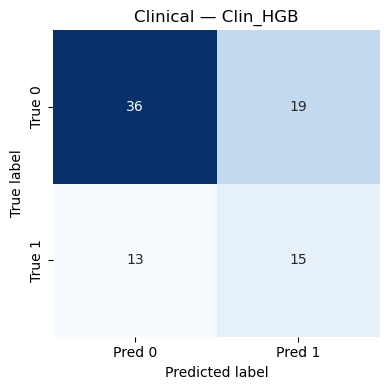

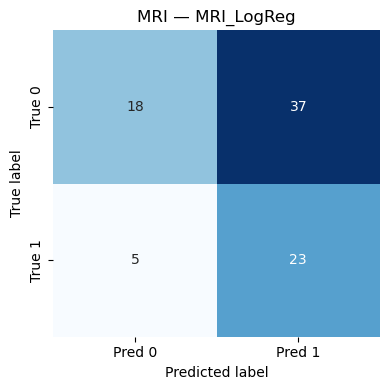

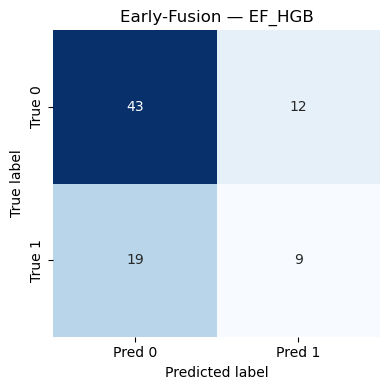

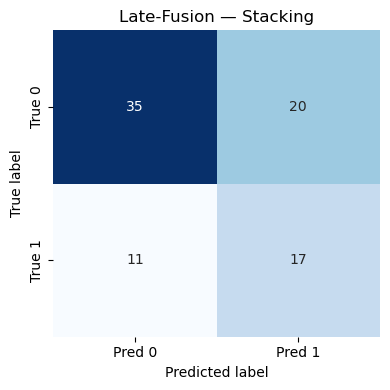

In [ ]:
# Confusion matrix

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=["Pred 0", "Pred 1"], 
                yticklabels=["True 0", "True 1"])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_confusion_matrix(cm_clin, "Clinical — Clin_HGB")
plot_confusion_matrix(cm_mri,  "MRI — MRI_LogReg")
plot_confusion_matrix(cm_ef,   "Early-Fusion — EF_HGB")
plot_confusion_matrix(cm_lf,   "Late-Fusion — Stacking")


In [ ]:
best_mri_logreg = next(r for r in all_model_results 
                       if r["name"] == "MRI_LogReg")["best_estimator"]

def coef_table_from_logreg_pipeline(pipe):
    prep = pipe.named_steps["prep"]
    clf  = pipe.named_steps["clf"]          # LogisticRegression
    
    # 1) Transformed Feature Name
    try:
        feat_names = prep.get_feature_names_out()
    except AttributeError:
        feat_names = np.array([f"feat_{i}" for i in range(clf.coef_.shape[1])])

    beta = clf.coef_.ravel()
    OR   = np.exp(beta)

    print("len(feat_names) =", len(feat_names))
    print("len(beta)       =", len(beta))   

    df = (pd.DataFrame({
            "Feature": feat_names,
            "Beta": beta,
            "Odds_Ratio": OR
        })
        .assign(Abs_Beta=lambda d: d["Beta"].abs())
        .sort_values("Abs_Beta", ascending=False)
    )
    return df

coef_mri = coef_table_from_logreg_pipeline(best_mri_logreg)
coef_mri.head(20)


len(feat_names) = 45
len(beta)       = 45


,Feature,Beta,Odds_Ratio,Abs_Beta
27,mri__lh_superiorfrontal_thickness,-1.187348,0.305029,1.187348
12,mri__rh_paracentral_area,1.150678,3.160336,1.150678
14,mri__rh_posteriorcingulate_area,-1.107749,0.330302,1.107749
42,mri__rh_posteriorcingulate_volume,1.098086,2.998422,1.098086
30,mri__rh_lateraloccipital_thickness,-0.957064,0.384019,0.957064
24,mri__lh_parsopercularis_thickness,0.915499,2.498020,0.915499
41,mri__rh_paracentral_volume,-0.891400,0.410081,0.891400
6,mri__lh_superiortemporal_area,-0.881764,0.414052,0.881764
43,mri__rh_superiortemporal_volume,-0.847137,0.428640,0.847137
4,mri__lh_parsorbitalis_area,0.840322,2.317113,0.840322


In [ ]:
# 1) Extract the preprocessor and the final LogReg
prep = best_mri_logreg.named_steps["prep"]
clf  = best_mri_logreg.named_steps["clf"]

# 2) transform test-set
X_te_mri_raw = X_te[mri_cols]                 
X_te_mri_tr  = prep.transform(X_te_mri_raw)   

# 3) Ensure feature names align with transformed columns.
feat_names_mri = prep.get_feature_names_out(mri_cols)  

print("X_te_mri_tr shape:", X_te_mri_tr.shape)
print("len(feat_names_mri):", len(feat_names_mri))

# 4) Permutation importance on the transformed space
result = permutation_importance(
    clf,
    X_te_mri_tr,
    y_te,
    n_repeats=30,
    random_state=42,
    scoring="average_precision",  # 或 "f1"
)

perm_df = (
    pd.DataFrame({
        "Feature": feat_names_mri,
        "Importance": result["importances_mean"],
        "Std": result["importances_std"],
    })
    .sort_values("Importance", ascending=False)
)

perm_df.head(20)


X_te_mri_tr shape: (83, 45)
len(feat_names_mri): 45


,Feature,Importance,Std
42,mri__rh_posteriorcingulate_volume,0.053287,0.036021
6,mri__lh_superiortemporal_area,0.048213,0.023040
41,mri__rh_paracentral_volume,0.033408,0.018165
10,mri__lh_insula_area,0.030957,0.022519
14,mri__rh_posteriorcingulate_area,0.020480,0.038686
38,mri__lh_transversetemporal_volume,0.017532,0.021329
27,mri__lh_superiorfrontal_thickness,0.017161,0.043068
20,mri__lh_entorhinal_thickness,0.017060,0.022872
3,mri__lh_parsopercularis_area,0.015775,0.009147
18,mri__lh_bankssts_thickness,0.014595,0.019126


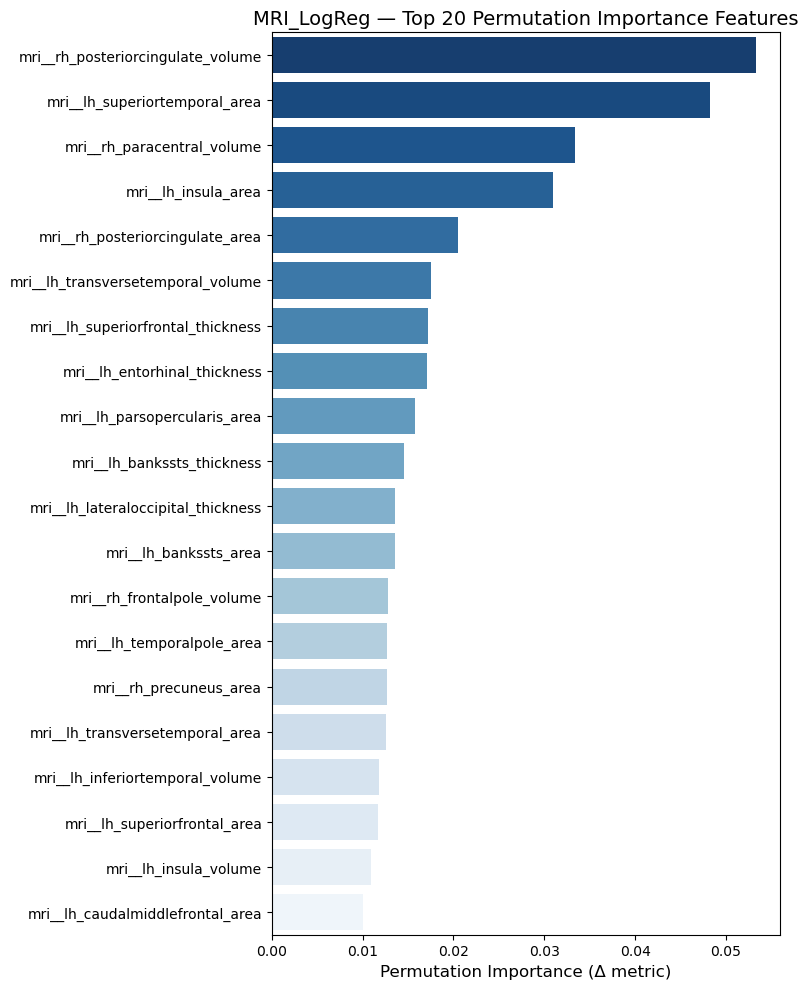

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top20
topk = perm_df.sort_values("Importance", ascending=False).head(20)

plt.figure(figsize=(8, 10))
sns.barplot(
    data=topk,
    x="Importance",
    y="Feature",
    palette="Blues_r"
)

plt.title("MRI_LogReg — Top 20 Permutation Importance Features", fontsize=14)
plt.xlabel("Permutation Importance (Δ metric)", fontsize=12)
plt.ylabel("")
plt.tight_layout()
plt.show()



<class 'sklearn.compose._column_transformer.ColumnTransformer'> <class 'sklearn.linear_model._logistic.LogisticRegression'>
Train prepared shape: (332, 45)
Test  prepared shape: (83, 45)
Number of selected MRI features: 45
SHAP array shape: (83, 45)


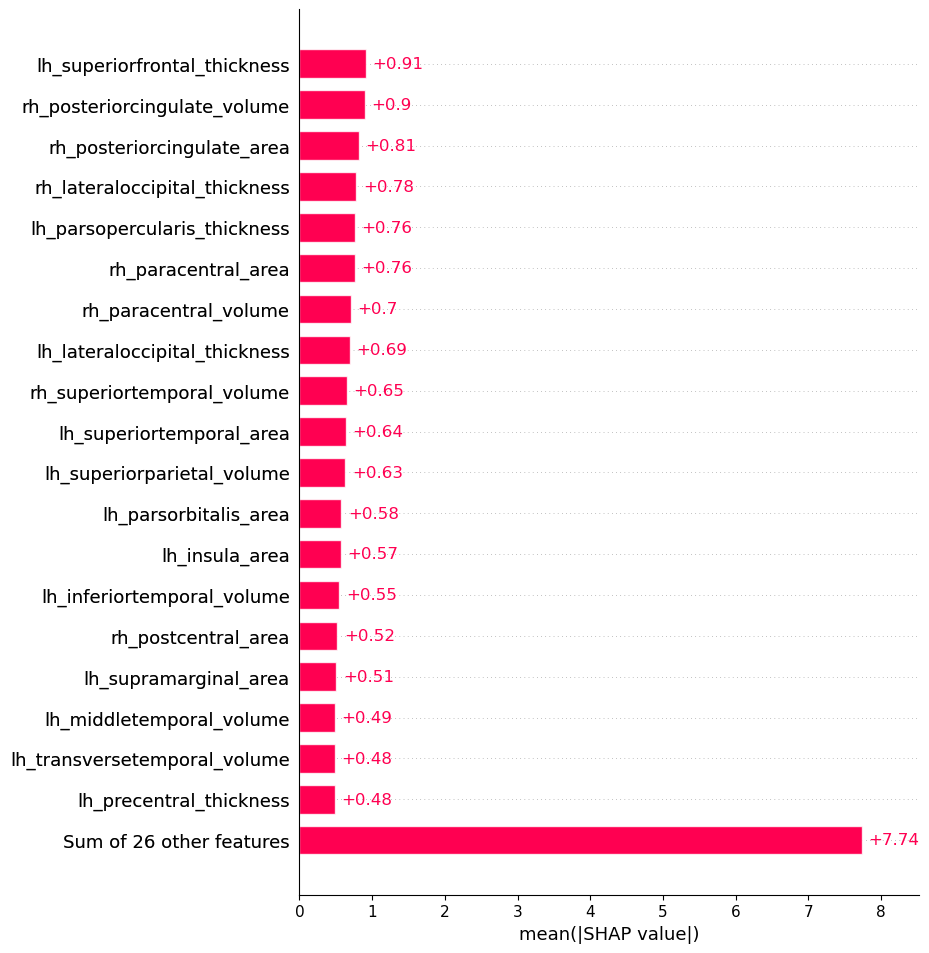

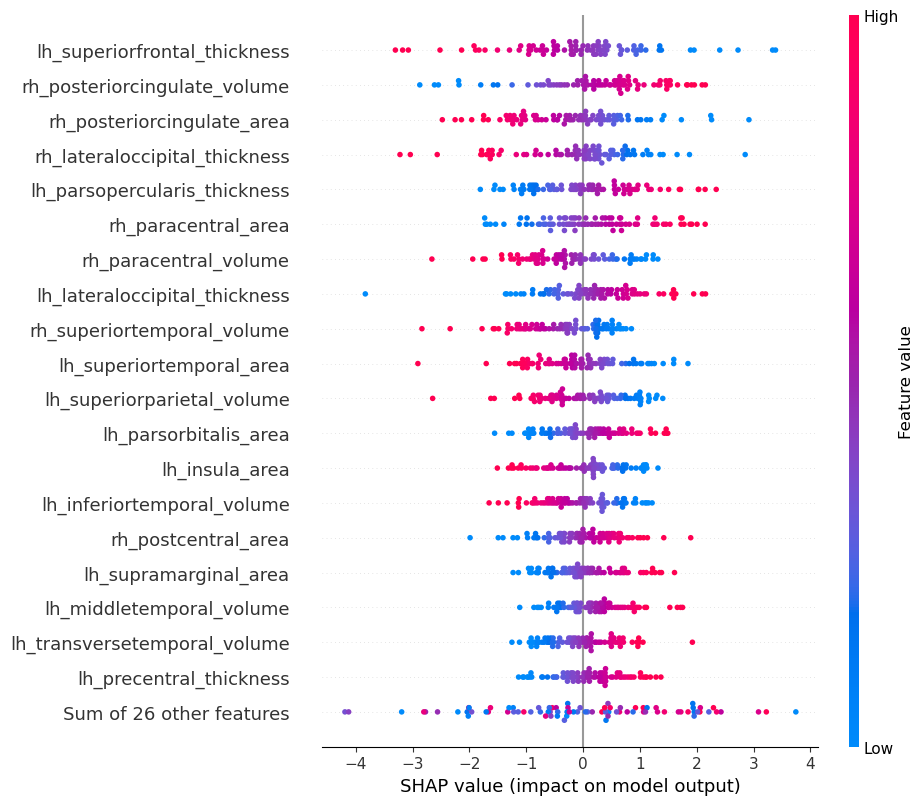

In [ ]:
# SHAP for MRI_LogReg (Logistic Regression)

# 1) Remove preprocessing and LogReg from the pipeline.
pipe_mri = best_mri_logreg              
prep_mri = pipe_mri.named_steps["prep"] 
clf_mri  = pipe_mri.named_steps["clf"]  

print(type(prep_mri), type(clf_mri))

# 2) Transform the MRI features
X_tr_mri = X_tr[mri_cols].copy()
X_te_mri = X_te[mri_cols].copy()

X_tr_prep = prep_mri.transform(X_tr_mri)
X_te_prep = prep_mri.transform(X_te_mri)

print("Train prepared shape:", X_tr_prep.shape)
print("Test  prepared shape:", X_te_prep.shape)

# 3) Feature Name
mri_branch_name, mri_branch_pipe, mri_branch_cols = prep_mri.transformers_[0]
# mri_branch_pipe 是一个 Pipeline(imp -> scaler -> sel)

selector = mri_branch_pipe.named_steps["sel"]
support_mask = selector.get_support()          # True/False, length = len(mri_branch_cols)
feat_names_mri = np.array(mri_branch_cols)[support_mask]

print("Number of selected MRI features:", len(feat_names_mri))


# 4) LinearExplainer
if X_tr_prep.shape[0] > 200:
    rng = np.random.RandomState(42)
    bg_idx = rng.choice(X_tr_prep.shape[0], 200, replace=False)
    X_bg = X_tr_prep[bg_idx]
else:
    X_bg = X_tr_prep


explainer = shap.LinearExplainer(
    clf_mri,        
    X_bg,           
    feature_names=feat_names_mri
)

# SHAP value on test set
shap_values = explainer.shap_values(X_te_prep)
expected_value = explainer.expected_value

# Return format compatible with different shap versions:
shap_arr = np.array(shap_values)
if shap_arr.ndim == 3:
    shap_arr = shap_arr[1]   

print("SHAP array shape:", shap_arr.shape)  

#  5) Construct an Explanation object (new drawing interface)
exp = shap.Explanation(
    values=shap_arr,
    base_values=np.repeat(expected_value, X_te_prep.shape[0]),
    data=X_te_prep,
    feature_names=feat_names_mri
)

# 6) Top 20
shap.plots.bar(exp, max_display=20)

# 7) SHAP beeswarm
shap.plots.beeswarm(exp, max_display=20)

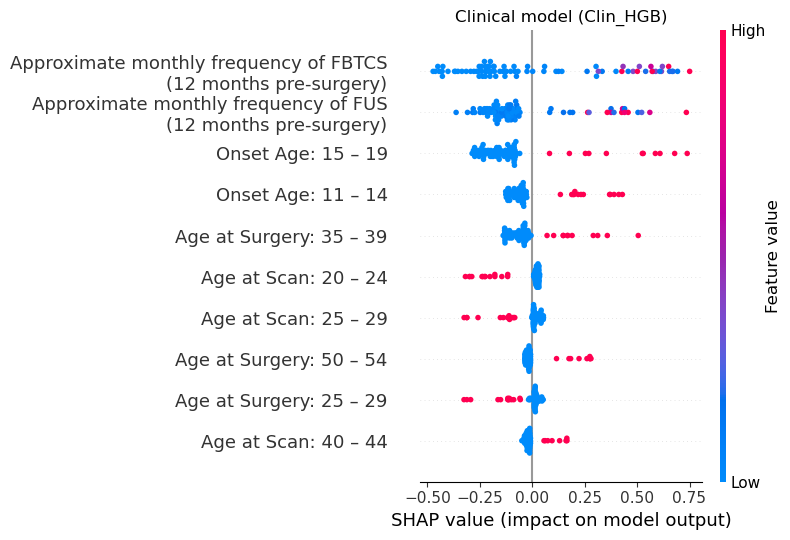

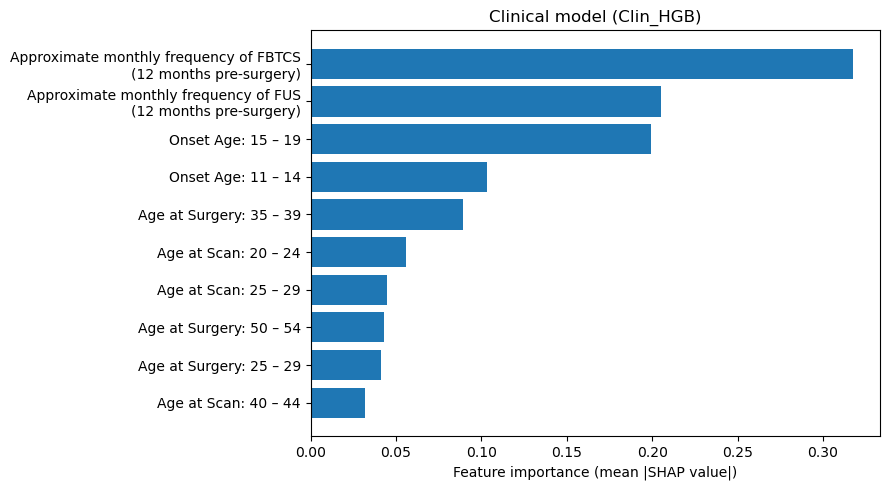

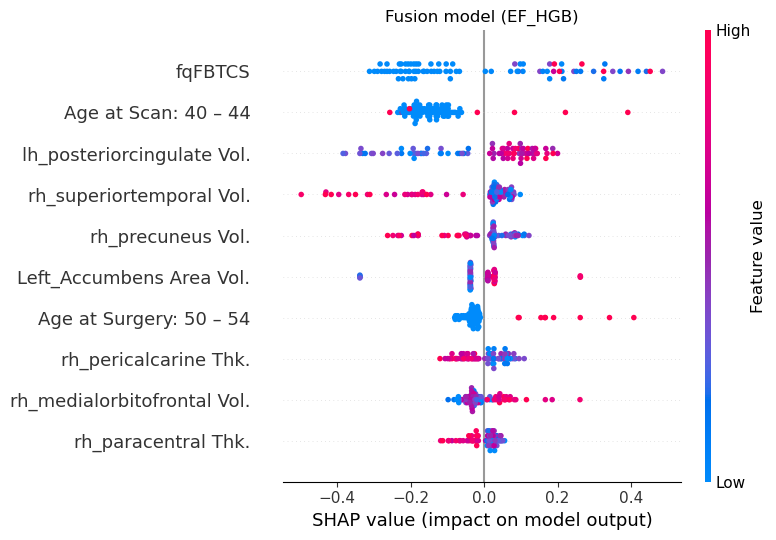

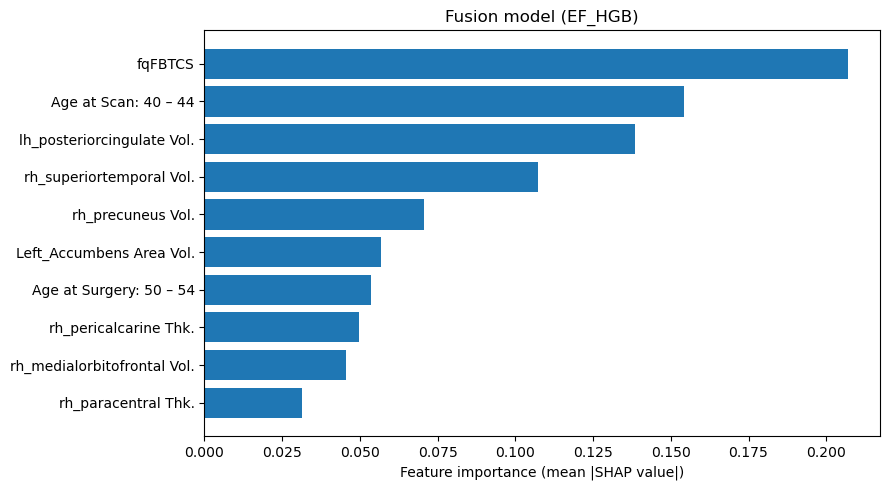

In [ ]:
# SHAP summary (clean labels) for Clin_HGB & EF_HGB on TEST

# 0) Description Mapping 
full_explanation_map = {
    "FUS": "Focal Unaware Seizures (FUS) History\n(12 months pre-surgery: True/False)",
    "fqFUS": "Approximate monthly frequency of FUS\n(12 months pre-surgery)",
    "FBTCS": "Focal to Bilateral Tonic Clonic Seizures (FBTCS)\n(12 months pre-surgery: True/False)",
    "fqFBTCS": "Approximate monthly frequency of FBTCS\n(12 months pre-surgery)",
    "SE": "History of Status Epilepticus (SE)\n(True/False)",
    "Number_ASMs": "Number of Antiseizure Medications (ASMs)\nat surgery",
    "Op_Side": "Hemisphere of Resection (Left/Right)",
    "Op_Type": "Lobe and Type of Resection (T, F, O, P, Lx, Lesx, Hx)",
    "Pathology": "Histopathology ([HS] Hippocampal Sclerosis, [DNT] Dysembryoplastic tumour, [CAV] Cavernoma, [GL] Glioma, [FCD] Focal Cortical Dysplasia, [EFG] End-folium gliosis, [Double] Two, [Treble] Three)",
    "ILAE_Year": "Yearly outcomes of Seizure-Freedom (ILAE)",
    "Sex": "Sex",
    "Onset_Age": "Onset Age",
    "Age_at_Scan": "Age at Scan",
    "Age_at_Surgery": "Age at Surgery"
}

TOPK = 10  

# 1) Select the optimal model 
def _best_estimator(results, name):
    for r in results:
        if r["name"] == name:
            return clone(r["best_estimator"])
    raise ValueError(f"{name} not found in results.")

clin_hgb_pipe = _best_estimator(all_model_results, "Clin_HGB")
ef_hgb_pipe   = _best_estimator(ef_results,        "EF_HGB")

# 2) Set of Lists
clin_cols = clin_num_cols + clin_cat_cols
ef_cols   = list(X_tr.columns)

# 3) Fitting 
clin_hgb_pipe.fit(X_tr[clin_cols], y_tr)
ef_hgb_pipe.fit(X_tr[ef_cols],     y_tr)

prep_clin = clin_hgb_pipe.named_steps["prep"]; clf_clin = clin_hgb_pipe.named_steps["clf"]
prep_ef   = ef_hgb_pipe.named_steps["prep"];   clf_ef   = ef_hgb_pipe.named_steps["clf"]

# 4) Preprocessing TEST 
Xte_clin_prep = prep_clin.transform(X_te[clin_cols])
Xte_ef_prep   = prep_ef.transform(X_te[ef_cols])

def _safe_feature_names(prep, n_cols):
    try:
        return np.array(prep.get_feature_names_out())
    except Exception:
        return np.array([f"feat_{i}" for i in range(n_cols)])

feat_names_clin_raw = _safe_feature_names(prep_clin, Xte_clin_prep.shape[1])
feat_names_ef_raw   = _safe_feature_names(prep_ef,   Xte_ef_prep.shape[1])

# 5) Name Cleaning 
def simplify_feature_name(name):
    for prefix in ("num__", "cat__", "mri__"):
        if name.startswith(prefix):
            name = name[len(prefix):]
    name = name.replace("_volume", " Vol.").replace("_thickness", " Thk.").replace("_area", " Area")

    def _fmt(bin_txt, label):
        pretty = bin_txt.replace("to", "–").replace("_", "–").replace("-", "–")
        return f"{label}: {pretty}"
    if name.startswith("Binned_Age_at_Surgery_"):
        return _fmt(name.split("Binned_Age_at_Surgery_")[1], "Age at Surgery")
    if name.startswith("Binned_Age_at_Scan_"):
        return _fmt(name.split("Binned_Age_at_Scan_")[1], "Age at Scan")
    if name.startswith("Binned_Onset_Age_"):
        return _fmt(name.split("Binned_Onset_Age_")[1], "Onset Age")
    return name

def _base_key_from_ohe_name(name, mapping_keys):
    raw = name
    for prefix in ("num__", "cat__", "mri__"):
        if raw.startswith(prefix):
            raw = raw[len(prefix):]
    for key in mapping_keys:
        if raw == key or raw.startswith(key + "_") or raw.startswith(key + "[") or raw.startswith(key + "("):
            return key
    return None


mapped_names_clin = []
for nm in feat_names_clin_raw:
    base = _base_key_from_ohe_name(nm, full_explanation_map.keys())
    disp = full_explanation_map.get(base, nm)
    mapped_names_clin.append(simplify_feature_name(disp))
feat_names_clin = np.array(mapped_names_clin)


feat_names_ef = np.array([simplify_feature_name(nm) for nm in feat_names_ef_raw])

# 6) TreeExplainer & SHAP
exp_clin = shap.TreeExplainer(clf_clin)
exp_ef   = shap.TreeExplainer(clf_ef)
sh_clin  = exp_clin.shap_values(Xte_clin_prep)  # (n, d)
sh_ef    = exp_ef.shap_values(Xte_ef_prep)

def topk_by_mean_abs(sh_vals, feat_names, X_prep, k=TOPK):
    mean_abs = np.abs(sh_vals).mean(axis=0)
    order = np.argsort(-mean_abs)[:k]
    return sh_vals[:, order], feat_names[order], X_prep[:, order], mean_abs[order]

sh_clin_top, names_clin_top, X_clin_top, meanabs_clin = topk_by_mean_abs(sh_clin, feat_names_clin, Xte_clin_prep, TOPK)
sh_ef_top,   names_ef_top,   X_ef_top,   meanabs_ef   = topk_by_mean_abs(sh_ef,   feat_names_ef,   Xte_ef_prep,   TOPK)



def save_beeswarm(sh_vals, Xp, names, title, png_name, width=9, height=6):
    plt.figure(figsize=(width, height))
    shap.summary_plot(sh_vals, Xp, feature_names=names, show=False, max_display=len(names))
    plt.title(title)
    plt.tight_layout()
    plt.savefig(png_name, dpi=300)
    plt.show()

def save_bar(mean_abs, names, title, png_name, width=9, height=5):
   
    order = np.argsort(mean_abs)
    plt.figure(figsize=(width, height))
    plt.barh(np.array(names)[order], np.array(mean_abs)[order])
    plt.xlabel("Feature importance (mean |SHAP value|)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(png_name, dpi=300)
    plt.show()

# Clin_HGB
save_beeswarm(
    sh_clin_top, X_clin_top, names_clin_top,
    "Clinical model (Clin_HGB)",        
    "Clin_HGB_test_beeswarm_clean.png"
)
save_bar(
    meanabs_clin, names_clin_top,
    "Clinical model (Clin_HGB)",       
    "Clin_HGB_test_bar_clean.png"
)

# EF_HGB
save_beeswarm(
    sh_ef_top, X_ef_top, names_ef_top,
    "Fusion model (EF_HGB)",         
    "EF_HGB_test_beeswarm_clean.png"
)
save_bar(
    meanabs_ef, names_ef_top,
    "Fusion model (EF_HGB)",        
    "EF_HGB_test_bar_clean.png"
)



In [ ]:
pd.DataFrame({'feature': names_clin_top, 'mean_shap': sh_clin_top.mean(axis=0)})

,feature,mean_shap
0,Approximate monthly frequency of FBTCS\n(12 mo...,0.019748
1,Approximate monthly frequency of FUS\n(12 mont...,-0.030573
2,Onset Age: 15 – 19,-0.083443
3,Onset Age: 11 – 14,-0.016728
4,Age at Surgery: 35 – 39,-0.029744
5,Age at Scan: 20 – 24,-0.018164
6,Age at Scan: 25 – 29,-0.011498
7,Age at Surgery: 50 – 54,0.006505
8,Age at Surgery: 25 – 29,-0.011352
9,Age at Scan: 40 – 44,-0.009734
